# 🔍 Outlier & Anomaly Exploration Analysis

## Overview
This notebook explores the **excluded data** from the main anomaly detection analysis. It focuses on understanding trips that were filtered out due to extreme values, outliers, or anomalies.

## 📋 Analysis Focus

1. **Data Loading & Feature Engineering** - Load data and calculate derived metrics
2. **Filter Application** - Apply quality filters to identify what gets excluded
3. **Excluded Data Analysis** - Deep dive into trips that didn't pass filters
4. **Outlier Characterization** - Understand patterns in extreme values
5. **Comparison** - Compare excluded vs included data distributions

## 🎯 Key Questions

- What trips were excluded by quality filters?
- What are the characteristics of high trip_seq values (>3)?
- What causes extreme distance ratios (>4.36)?
- Are there patterns in extreme speeds (>100 km/h)?
- Which users have the most excluded trips?

## 🔬 Exclusion Criteria

**Quality Filters**:
- Distance ≤ 0.5 km (too short)
- Duration ≤ 1 minute (too quick)
- Speed > 100 km/h (unrealistic)
- Speed ≤ 0 km/h (invalid)

**Additional Filters**:
- trip_seq > 3 (high sequence numbers)
- distance_ratio > 4.36 (extreme detours)

**Result**: Approximately **30,000 trips excluded** from the 61k total dataset

## 📊 Analysis Outputs

This notebook produces:
- **Excluded data statistics** - Distributions of filtered-out trips
- **Outlier patterns** - Common characteristics of anomalies
- **User analysis** - Who has the most excluded trips
- **Visualizations** - Charts showing outlier distributions
- **CSV exports** - All excluded trips for further investigation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Optional: For BigQuery (uncomment if needed)
# import pydata_google_auth
# import pandas_gbq

print('Libraries imported successfully!')
print(f'  - pandas: {pd.__version__}')
print(f'  - numpy: {np.__version__}')

Libraries imported successfully!
  - pandas: 2.2.2
  - numpy: 1.26.4


## Section 2: Data Loading

Load trip data from CSV (recommended) or BigQuery.

In [2]:
# OPTION 1: Load from CSV (RECOMMENDED - Faster, no authentication needed)
csv_path = Path('trip_data.csv')

if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f'✓ Data loaded from CSV: {df.shape}')
    print(f'  - Rows: {len(df):,}')
    print(f'  - Columns: {len(df.columns)}')
else:
    raise FileNotFoundError(f'{csv_path} not found. Please ensure the data file exists or use BigQuery extraction below.')

✓ Data loaded from CSV: (61345, 34)
  - Rows: 61,345
  - Columns: 34


In [8]:
# OPTION 2: BigQuery Extraction (OPTIONAL - Uncomment to use)
# Keep this code for reference, but CSV loading is preferred for performance

import pydata_google_auth
import pandas_gbq


# Uncomment this section to extract data from BigQuery:

SCOPES = ["https://www.googleapis.com/auth/bigquery"]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)

query = '''
WITH del_user AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'deleted user'
),
block_by_dmd AS (
  SELECT DISTINCT user_id
  FROM `datamart.bbr_fraud_monitor`
  WHERE flag_indicator = 'blocked by DMD'
)

SELECT b1.*
FROM `L1.bbr_fact_ps_trip_score` b1
LEFT JOIN del_user du 
  ON b1.user_id = du.user_id
LEFT JOIN block_by_dmd db 
  ON b1.user_id = db.user_id
WHERE b1.eot = 'Y'
  AND NOT EXISTS (
    SELECT 1
    FROM `L1.bbr_dim_user_xanh` u
    WHERE u.user_id = b1.user_id
  )
  AND du.user_id IS NULL     -- exclude deleted users
  AND db.user_id IS NULL;    -- exclude blocked users

'''

df = pandas_gbq.read_gbq(
    query,
    project_id="lgi-dt-dwh",
    credentials=credentials,
)

# Save to CSV for faster subsequent loads
df.to_csv('trip_data.csv', index=False)
print(f'✓ Data extracted from BigQuery and saved to trip_data.csv: {df.shape}')


print('✓ BigQuery code available (commented out). Using CSV load by default.')

Downloading: 100%|██████████|
✓ Data extracted from BigQuery and saved to trip_data.csv: (61345, 34)
✓ BigQuery code available (commented out). Using CSV load by default.


**⚠️ DATA SOURCE NOTE:**

The data used in this analysis has been **pre-filtered** to exclude:
- Users flagged as **fake accounts**
- Users **blocked by DMD** (Data Management Department)
- Trips where **eot ≠ 'Y'** (End of Trip flag)
- **XANH SM users**

This ensures we're analyzing only legitimate user trips for anomaly detection.

## Section 3: Feature Engineering

Calculate Haversine distance, distance difference, duration, and other derived features.

In [3]:
# Haversine formula to calculate straight-line GPS distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate great-circle distance between two points on Earth using Haversine formula.
    
    Parameters:
        lat1, lon1: Starting point coordinates (degrees)
        lat2, lon2: Ending point coordinates (degrees)
    
    Returns:
        Distance in kilometers
    """
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Calculate Haversine distance
df['distance_haversine'] = haversine(
    df['latitude_from'], 
    df['longitude_from'], 
    df['latitude_to'], 
    df['longitude_to']
)

print('✓ Haversine distance calculated!')
print(f'  - Mean haversine distance: {df["distance_haversine"].mean():.2f} km')
print(f'  - Max haversine distance: {df["distance_haversine"].max():.2f} km')

✓ Haversine distance calculated!
  - Mean haversine distance: 64.26 km
  - Max haversine distance: 10307.44 km


In [4]:
# Convert dates to datetime and calculate duration
df['driving_date_from'] = pd.to_datetime(df['driving_date_from'])
df['driving_date_to'] = pd.to_datetime(df['driving_date_to'])
df['trip_duration_seconds'] = (df['driving_date_to'] - df['driving_date_from']).dt.total_seconds()
df['trip_duration_minutes'] = df['trip_duration_seconds'] / 60

# Absolute detour distance (km)
df['distance_diff_km'] = df['distance'] - df['distance_haversine']

# Route efficiency ratio (>= 1 is expected)
df['distance_ratio'] = (df['distance'] / df['distance_haversine'].replace(0, np.nan))

# Average speed using driving_time (km/h)
df['avg_speed_kmh'] = df['distance'] / (df['driving_time'] / 3600).replace(0, np.nan)

print('✓ Engineered features calculated:')
print('  - trip_duration_seconds / minutes')
print('  - distance_diff_km')
print('  - distance_ratio')
print('  - avg_speed_kmh (driving_time)')

✓ Engineered features calculated:
  - trip_duration_seconds / minutes
  - distance_diff_km
  - distance_ratio
  - avg_speed_kmh (driving_time)


In [5]:
df[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .05, .5, .95, .99])


,distance,distance_diff_km,trip_duration_minutes,distance_ratio,avg_speed_kmh,trip_seq
count,61345.000000,6.134500e+04,61345.000000,59683.000000,6.129700e+04,61345.000000
mean,78.930287,1.466730e+01,33.304023,41.260742,1.328407e+04,1.009341
std,302.555450,1.849896e+02,101.311498,591.579481,5.325609e+04,0.205622
min,0.000000,-1.030744e+04,-10078.633333,0.000000,-5.098427e-05,1.000000
1%,0.000000,-4.287926e-11,0.100000,1.000000,0.000000e+00,1.000000
5%,0.001444,9.449712e-12,0.200000,1.000000,1.038624e-01,1.000000
50%,5.764246,8.000676e-01,11.850000,1.522263,1.592709e+01,1.000000
95%,403.672993,2.859852e+01,129.723333,14.487934,8.570377e+04,1.000000
99%,1410.483642,1.557302e+02,272.292667,745.813952,2.715849e+05,1.000000
max,13489.877104,1.121875e+04,8339.516667,48333.080002,2.869562e+06,24.000000


In [20]:
# INVESTIGATE: trip_duration_minutes vs driving_time
# ===================================================

print("=" * 100)
print(" " * 20 + "🔍 COMPARING trip_duration_minutes vs driving_time")
print("=" * 100)

# Calculate alternative speed using trip_duration_minutes
df['avg_speed_kmh_alt'] = df['distance'] / (df['trip_duration_minutes'] / 60).replace(0, np.nan)

# Convert driving_time to minutes for comparison
df['driving_time_minutes'] = df['driving_time'] / 60

# Compare the two duration metrics
print("\n📊 Duration Metrics Comparison:")
print(f"\n1. trip_duration_minutes (from timestamp: driving_date_to - driving_date_from)")
print(f"   • Mean: {df['trip_duration_minutes'].mean():.2f} min")
print(f"   • Median: {df['trip_duration_minutes'].median():.2f} min")
print(f"   • Min: {df['trip_duration_minutes'].min():.2f} min")
print(f"   • Max: {df['trip_duration_minutes'].max():.2f} min")
print(f"   • Std Dev: {df['trip_duration_minutes'].std():.2f} min")
print(f"   • NaN count: {df['trip_duration_minutes'].isna().sum():,}")

print(f"\n2. driving_time_minutes (from database driving_time field ÷ 60)")
print(f"   • Mean: {df['driving_time_minutes'].mean():.2f} min")
print(f"   • Median: {df['driving_time_minutes'].median():.2f} min")
print(f"   • Min: {df['driving_time_minutes'].min():.2f} min")
print(f"   • Max: {df['driving_time_minutes'].max():.2f} min")
print(f"   • Std Dev: {df['driving_time_minutes'].std():.2f} min")
print(f"   • NaN count: {df['driving_time_minutes'].isna().sum():,}")

# Check if they are the same
df['duration_match'] = np.isclose(df['trip_duration_minutes'], df['driving_time_minutes'], rtol=0.01)
match_count = df['duration_match'].sum()
match_pct = (match_count / len(df)) * 100

print(f"\n🔗 Comparison Result (within 1% tolerance):")
print(f"   • Trips where durations match: {match_count:,} / {len(df):,} ({match_pct:.1f}%)")
print(f"   • Trips where durations differ: {len(df) - match_count:,} ({100-match_pct:.1f}%)")

# Show sample differences
df['duration_diff_minutes'] = df['trip_duration_minutes'] - df['driving_time_minutes']
df['duration_diff_pct'] = (df['duration_diff_minutes'] / df['driving_time_minutes'] * 100).replace([np.inf, -np.inf], np.nan)

print(f"\n📈 Differences between duration metrics:")
print(f"   • Mean difference: {df['duration_diff_minutes'].mean():.3f} min")
print(f"   • Median difference: {df['duration_diff_minutes'].median():.3f} min")
print(f"   • Max difference: {df['duration_diff_minutes'].max():.3f} min")
print(f"   • Min difference: {df['duration_diff_minutes'].min():.3f} min")

# Compare speeds calculated with both methods
print(f"\n⚡ Speed Calculation Comparison:")
print(f"\n1. Using driving_time (current method):")
print(f"   • avg_speed_kmh = distance / (driving_time / 3600)")
print(f"   • Mean: {df['avg_speed_kmh'].mean():.2f} km/h")
print(f"   • Median: {df['avg_speed_kmh'].median():.2f} km/h")
print(f"   • Trips > 100 km/h: {(df['avg_speed_kmh'] > 100).sum():,}")

print(f"\n2. Using trip_duration_minutes (alternative method):")
print(f"   • avg_speed_kmh_alt = distance / (trip_duration_minutes / 60)")
print(f"   • Mean: {df['avg_speed_kmh_alt'].mean():.2f} km/h")
print(f"   • Median: {df['avg_speed_kmh_alt'].median():.2f} km/h")
print(f"   • Trips > 100 km/h: {(df['avg_speed_kmh_alt'] > 100).sum():,}")

# Compare the two speed calculations
df['speed_match'] = np.isclose(df['avg_speed_kmh'], df['avg_speed_kmh_alt'], rtol=0.01)
speed_match_count = df['speed_match'].sum()
speed_match_pct = (speed_match_count / len(df)) * 100

print(f"\n🔗 Speed Calculation Result (within 1% tolerance):")
print(f"   • Trips with matching speeds: {speed_match_count:,} / {len(df):,} ({speed_match_pct:.1f}%)")
print(f"   • Trips with different speeds: {len(df) - speed_match_count:,} ({100-speed_match_pct:.1f}%)")

# Show specific examples where they differ
print(f"\n📋 Sample of trips where durations differ significantly:")
significant_diff = df[abs(df['duration_diff_minutes']) > 5].sort_values('duration_diff_minutes', ascending=False).head(10)
if len(significant_diff) > 0:
    print("-" * 100)
    print(f"{'trip_id':>8} {'distance':>10} {'trip_dur_min':>12} {'driving_min':>12} {'diff_min':>10} {'diff_%':>10} {'speed_cur':>10} {'speed_alt':>10}")
    print("-" * 100)
    for idx, row in significant_diff.iterrows():
        print(f"{int(row['trip_id']):>8} {row['distance']:>10.2f} {row['trip_duration_minutes']:>12.2f} {row['driving_time_minutes']:>12.2f} {row['duration_diff_minutes']:>10.2f} {row['duration_diff_pct']:>10.1f} {row['avg_speed_kmh']:>10.2f} {row['avg_speed_kmh_alt']:>10.2f}")
else:
    print("   No significant differences found")

print("\n" + "=" * 100)


                    🔍 COMPARING trip_duration_minutes vs driving_time

📊 Duration Metrics Comparison:

1. trip_duration_minutes (from timestamp: driving_date_to - driving_date_from)
   • Mean: 33.30 min
   • Median: 11.85 min
   • Min: -10078.63 min
   • Max: 8339.52 min
   • Std Dev: 101.31 min
   • NaN count: 0

2. driving_time_minutes (from database driving_time field ÷ 60)
   • Mean: 33.30 min
   • Median: 11.83 min
   • Min: -10078.63 min
   • Max: 8339.52 min
   • Std Dev: 101.31 min
   • NaN count: 0

🔗 Comparison Result (within 1% tolerance):
   • Trips where durations match: 55,268 / 61,345 (90.1%)
   • Trips where durations differ: 6,077 (9.9%)

📈 Differences between duration metrics:
   • Mean difference: 0.006 min
   • Median difference: 0.000 min
   • Max difference: 0.017 min
   • Min difference: 0.000 min

⚡ Speed Calculation Comparison:

1. Using driving_time (current method):
   • avg_speed_kmh = distance / (driving_time / 3600)
   • Mean: 13284.07 km/h
   • Median: 15

### 📏 Metric Definitions
- `trip_duration_minutes`: Total trip time in minutes computed from `driving_date_to - driving_date_from`; negative or zero values signal timestamp/data issues.
- `distance_ratio`: Route efficiency = recorded `distance` ÷ straight-line `distance_haversine`; values close to 1 are efficient, higher values mean detours or GPS/route errors.
- `distance_diff_km`: Detour distance in km = recorded `distance` minus straight-line 
- `distance_haversine`; large positive values mean long detours, negative values imply GPS/path inconsistencies.
- `avg_speed_kmh`: Average speed in km/h using `distance` ÷ (`driving_time`/3600); extreme values usually indicate data quality problems.

In [6]:
# ============================================================================
# SECTION 3: CREATE FILTERED DATASET FOR ANALYSIS
# ============================================================================
# This filtered dataset is used by:
# - Cell 14: Distance ratio deep dive analysis
# - Cell 15: Anomaly detection (rule-based + IQR-based)
# - Cell 17: Comprehensive summary tables

print("=" * 100)
print(" " * 30 + "🔍 CREATING FILTERED DATASET FOR ANALYSIS")
print("=" * 100)

# Apply quality filters to create clean dataset
df_filtered = df[
    (df['distance'] > 0.5) &
    (df['trip_duration_minutes'] > 1) &
    (df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] <= 100)
].copy()

# Create trip_seq <= 3 filtered dataset for analysis
df_filtered_seq3 = df_filtered[pd.to_numeric(df_filtered['trip_seq'], errors='coerce') <= 3].copy()

# Create additional filter with distance_ratio <= 4.36 to remove extreme outliers
df_filtered_seq3_ratio = df_filtered_seq3[df_filtered_seq3['distance_ratio'] <= 4.36].copy()

print(f"\n📊 Filtering Results:")
print(f"  • Original Data: {len(df):,} trips")
print(f"  • Filtered Data (Quality): {len(df_filtered):,} trips ({len(df_filtered)/len(df)*100:.1f}% retained)")
print(f"  • Filtered Data (Quality + trip_seq ≤ 3): {len(df_filtered_seq3):,} trips ({len(df_filtered_seq3)/len(df)*100:.1f}% of original, {len(df_filtered_seq3)/len(df_filtered)*100:.1f}% of quality-filtered)")
print(f"  • Filtered Data (Quality + trip_seq ≤ 3 + ratio ≤ 4.36): {len(df_filtered_seq3_ratio):,} trips ({len(df_filtered_seq3_ratio)/len(df)*100:.1f}% of original, {len(df_filtered_seq3_ratio)/len(df_filtered_seq3)*100:.1f}% of seq3-filtered)")
print(f"\n📌 Quality Filters Applied:")
print(f"  • Distance > 0.5 km")
print(f"  • Duration > 1 minute")

# print(f"  • Distance Ratio: 1-1000 (valid range)")

print(f"  • Speed: 0-100 km/h (realistic range)")
print(f"  • trip_seq ≤ 3 (for df_filtered_seq3)")
print(f"  • distance_ratio ≤ 4.36 (for df_filtered_seq3_ratio - removes extreme detour outliers)")
print(f"\n✅ df_filtered, df_filtered_seq3, and df_filtered_seq3_ratio are ready for downstream analysis")


                              🔍 CREATING FILTERED DATASET FOR ANALYSIS

📊 Filtering Results:
  • Original Data: 61,345 trips
  • Filtered Data (Quality): 36,482 trips (59.5% retained)
  • Filtered Data (Quality + trip_seq ≤ 3): 36,437 trips (59.4% of original, 99.9% of quality-filtered)
  • Filtered Data (Quality + trip_seq ≤ 3 + ratio ≤ 4.36): 31,296 trips (51.0% of original, 85.9% of seq3-filtered)

📌 Quality Filters Applied:
  • Distance > 0.5 km
  • Duration > 1 minute
  • Speed: 0-100 km/h (realistic range)
  • trip_seq ≤ 3 (for df_filtered_seq3)
  • distance_ratio ≤ 4.36 (for df_filtered_seq3_ratio - removes extreme detour outliers)

✅ df_filtered, df_filtered_seq3, and df_filtered_seq3_ratio are ready for downstream analysis


In [7]:
# Identify EXCLUDED trips (those that didn't pass filters)
# ===========================================================

# Trips excluded by quality filters
excluded_quality = df[~df['trip_id'].isin(df_filtered['trip_id'])].copy()

# Trips excluded by trip_seq filter
excluded_seq = df_filtered[~df_filtered['trip_id'].isin(df_filtered_seq3['trip_id'])].copy()

# Trips excluded by distance_ratio filter
excluded_ratio = df_filtered_seq3[~df_filtered_seq3['trip_id'].isin(df_filtered_seq3_ratio['trip_id'])].copy()

# All excluded trips (not in final analysis base)
excluded_all = df[~df['trip_id'].isin(df_filtered_seq3_ratio['trip_id'])].copy()

print("=" * 100)
print(" " * 35 + "📊 EXCLUDED DATA OVERVIEW")
print("=" * 100)
print(f"\n✅ Total trips in dataset: {len(df):,}")
print(f"✅ Trips passing all filters (Final Base): {len(df_filtered_seq3_ratio):,}")
print(f"\n❌ EXCLUDED TRIPS BREAKDOWN:")
print(f"  • Total excluded: {len(excluded_all):,} trips ({len(excluded_all)/len(df)*100:.1f}%)")
print(f"  • Excluded by quality filters: {len(excluded_quality):,} trips ({len(excluded_quality)/len(df)*100:.1f}%)")
print(f"  • Excluded by trip_seq > 3: {len(excluded_seq):,} trips ({len(excluded_seq)/len(df)*100:.1f}%)")
print(f"  • Excluded by distance_ratio > 4.36: {len(excluded_ratio):,} trips ({len(excluded_ratio)/len(df)*100:.1f}%)")

# Show statistics of EXCLUDED data
print("\n" + "=" * 100)
print("EXCLUDED TRIPS - DESCRIPTIVE STATISTICS")
print("=" * 100)
excluded_all[[
    'distance',
    'distance_diff_km',
    'trip_duration_minutes',
    'distance_ratio',
    'avg_speed_kmh',
    'trip_seq'
]].describe(percentiles=[.01, .25, .50, .75, .90, .95, .99]).T

                                   📊 EXCLUDED DATA OVERVIEW

✅ Total trips in dataset: 61,345
✅ Trips passing all filters (Final Base): 31,296

❌ EXCLUDED TRIPS BREAKDOWN:
  • Total excluded: 30,049 trips (49.0%)
  • Excluded by quality filters: 24,863 trips (40.5%)
  • Excluded by trip_seq > 3: 45 trips (0.1%)
  • Excluded by distance_ratio > 4.36: 5,141 trips (8.4%)

EXCLUDED TRIPS - DESCRIPTIVE STATISTICS


,count,mean,std,min,1%,25%,50%,75%,90%,95%,99%,max
distance,30049.0,146.740070,421.294388,0.000000,0.000000,0.021858,0.298639,95.984831,409.785002,722.534929,2064.578385,1.348988e+04
distance_diff_km,30049.0,24.162284,263.844434,-10307.442028,-0.016220,0.000188,0.003138,0.120808,19.239073,47.001857,747.125131,1.121875e+04
trip_duration_minutes,30049.0,24.055797,134.456950,-10078.633333,0.083333,0.300000,0.700000,6.100000,61.623333,128.293333,331.982000,8.339517e+03
distance_ratio,28387.0,84.768398,855.686245,0.000000,0.000001,1.000004,1.211649,4.809676,15.675246,67.368149,2037.974332,4.833308e+04
avg_speed_kmh,30001.0,27120.903673,73620.243825,-0.000051,0.000000,0.996939,10.857478,13014.348084,87598.684700,171802.357860,341348.959843,2.869562e+06
trip_seq,30049.0,1.016140,0.286661,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.400000e+01


In [8]:
# ANALYZE WHY TRIPS WERE EXCLUDED
# =================================

print("=" * 100)
print(" " * 30 + "🔍 EXCLUSION REASONS ANALYSIS")
print("=" * 100)

# Categorize exclusion reasons for quality-excluded trips
quality_reasons = pd.DataFrame()

quality_reasons['too_short_distance'] = (df['distance'] <= 0.5)
quality_reasons['too_short_duration'] = (df['trip_duration_minutes'] <= 1)
quality_reasons['speed_too_high'] = (df['avg_speed_kmh'] > 100)
quality_reasons['speed_invalid'] = (df['avg_speed_kmh'] <= 0) | df['avg_speed_kmh'].isna()

print("\n📋 Quality Filter Violations (trips failing each criterion):")
print(f"  • Distance ≤ 0.5 km: {quality_reasons['too_short_distance'].sum():,} trips ({quality_reasons['too_short_distance'].sum()/len(df)*100:.2f}%)")
print(f"  • Duration ≤ 1 min: {quality_reasons['too_short_duration'].sum():,} trips ({quality_reasons['too_short_duration'].sum()/len(df)*100:.2f}%)")
print(f"  • Speed > 100 km/h: {quality_reasons['speed_too_high'].sum():,} trips ({quality_reasons['speed_too_high'].sum()/len(df)*100:.2f}%)")
print(f"  • Speed ≤ 0 or NaN: {quality_reasons['speed_invalid'].sum():,} trips ({quality_reasons['speed_invalid'].sum()/len(df)*100:.2f}%)")

# Count how many violations per trip
quality_reasons['total_violations'] = quality_reasons.sum(axis=1)
print(f"\n📊 Distribution of violations per trip:")
print(quality_reasons['total_violations'].value_counts().sort_index())

# Analyze trip_seq distribution
print(f"\n📊 Trip Sequence (trip_seq) Distribution:")
print(df['trip_seq'].value_counts().sort_index().head(10))
print(f"\nTrips with trip_seq > 3: {(df['trip_seq'] > 3).sum():,} ({(df['trip_seq'] > 3).sum()/len(df)*100:.2f}%)")

# Analyze distance_ratio extremes
print(f"\n📊 Distance Ratio Extremes:")
print(f"  • Ratio > 4.36: {(df_filtered_seq3['distance_ratio'] > 4.36).sum():,} trips")
print(f"  • Ratio > 5.0: {(df['distance_ratio'] > 5.0).sum():,} trips")
print(f"  • Ratio > 10.0: {(df['distance_ratio'] > 10.0).sum():,} trips")
print(f"  • Max ratio: {df['distance_ratio'].max():.2f}")
print(f"  • 99th percentile: {df['distance_ratio'].quantile(0.99):.2f}")

                              🔍 EXCLUSION REASONS ANALYSIS

📋 Quality Filter Violations (trips failing each criterion):
  • Distance ≤ 0.5 km: 16,286 trips (26.55%)
  • Duration ≤ 1 min: 16,544 trips (26.97%)
  • Speed > 100 km/h: 8,544 trips (13.93%)
  • Speed ≤ 0 or NaN: 1,862 trips (3.04%)

📊 Distribution of violations per trip:
total_violations
0    36482
1     7923
2    15507
3     1433
Name: count, dtype: int64

📊 Trip Sequence (trip_seq) Distribution:
trip_seq
1     61017
2       237
3        45
4        21
5         7
6         6
7         3
8         4
10        1
13        2
Name: count, dtype: int64

Trips with trip_seq > 3: 46 (0.07%)

📊 Distance Ratio Extremes:
  • Ratio > 4.36: 5,141 trips
  • Ratio > 5.0: 6,842 trips
  • Ratio > 10.0: 3,896 trips
  • Max ratio: 48333.08
  • 99th percentile: 745.81


In [15]:
# DEEP DIVE INTO SPECIFIC EXCLUSION CATEGORIES
# ==============================================

print("=" * 100)
print(" " * 25 + "📊 DETAILED ANALYSIS OF EXCLUDED CATEGORIES")
print("=" * 100)

# 1. High Speed Trips (>100 km/h)
high_speed = df[df['avg_speed_kmh'] > 100].copy()
print(f"\n1️⃣ HIGH SPEED TRIPS (>100 km/h): {len(high_speed):,} trips")
if len(high_speed) > 0:
    print(f"   Speed range: {high_speed['avg_speed_kmh'].min():.1f} - {high_speed['avg_speed_kmh'].max():.1f} km/h")
    print(f"   Mean distance: {high_speed['distance'].mean():.2f} km")
    print(f"   Mean duration: {high_speed['trip_duration_minutes'].mean():.2f} min")
    print(f"   Unique users: {high_speed['user_id'].nunique():,}")

# 2. Extreme Distance Ratios (>4.36)
high_ratio = df[df['distance_ratio'] > 4.36].copy()
print(f"\n2️⃣ EXTREME DISTANCE RATIOS (>4.36): {len(high_ratio):,} trips")
if len(high_ratio) > 0:
    print(f"   Ratio range: {high_ratio['distance_ratio'].min():.2f} - {high_ratio['distance_ratio'].max():.2f}")
    print(f"   Mean recorded distance: {high_ratio['distance'].mean():.2f} km")
    print(f"   Mean straight-line distance: {high_ratio['distance_haversine'].mean():.2f} km")
    print(f"   Unique users: {high_ratio['user_id'].nunique():,}")

# 3. High Trip Sequence (>3)
high_seq = df[df['trip_seq'] > 3].copy()
print(f"\n3️⃣ HIGH TRIP SEQUENCE (>3): {len(high_seq):,} trips")
if len(high_seq) > 0:
    print(f"   trip_seq range: {high_seq['trip_seq'].min():.0f} - {high_seq['trip_seq'].max():.0f}")
    print(f"   Mean trip_seq: {high_seq['trip_seq'].mean():.2f}")
    print(f"   Unique users: {high_seq['user_id'].nunique():,}")
    print(f"   Top trip_seq values:")
    print(high_seq['trip_seq'].value_counts().head(10))

# 4. Very Short Trips (≤0.5 km)
short_distance = df[df['distance'] <= 0.5].copy()
print(f"\n4️⃣ VERY SHORT TRIPS (≤0.5 km): {len(short_distance):,} trips")
if len(short_distance) > 0:
    print(f"   Distance range: {short_distance['distance'].min():.3f} - {short_distance['distance'].max():.3f} km")
    print(f"   Mean duration: {short_distance['trip_duration_minutes'].mean():.2f} min")
    print(f"   Unique users: {short_distance['user_id'].nunique():,}")

# 5. Very Short Duration (≤1 min)
short_duration = df[df['trip_duration_minutes'] <= 1].copy()
print(f"\n5️⃣ VERY SHORT DURATION (≤1 min): {len(short_duration):,} trips")
if len(short_duration) > 0:
    print(f"   Duration range: {short_duration['trip_duration_minutes'].min():.2f} - {short_duration['trip_duration_minutes'].max():.2f} min")
    print(f"   Mean distance: {short_duration['distance'].mean():.2f} km")
    print(f"   Unique users: {short_duration['user_id'].nunique():,}")
    print(f"   Negative/zero durations: {(short_duration['trip_duration_minutes'] <= 0).sum():,}")

# 6. Invalid Speed (≤0 or NaN)
invalid_speed = df[(df['avg_speed_kmh'] <= 0) | df['avg_speed_kmh'].isna()].copy()
print(f"\n6️⃣ INVALID SPEED (≤0 or NaN): {len(invalid_speed):,} trips")
if len(invalid_speed) > 0:
    print(f"   NaN values: {invalid_speed['avg_speed_kmh'].isna().sum():,}")
    print(f"   Zero/negative: {(invalid_speed['avg_speed_kmh'] <= 0).sum():,}")
    print(f"   Unique users: {invalid_speed['user_id'].nunique():,}")

                         📊 DETAILED ANALYSIS OF EXCLUDED CATEGORIES

1️⃣ HIGH SPEED TRIPS (>100 km/h): 8,544 trips
   Speed range: 100.9 - 2869562.0 km/h
   Mean distance: 499.42 km
   Mean duration: 0.80 min
   Unique users: 484

2️⃣ EXTREME DISTANCE RATIOS (>4.36): 7,773 trips
   Ratio range: 4.36 - 48333.08
   Mean recorded distance: 78.22 km
   Mean straight-line distance: 8.29 km
   Unique users: 468

3️⃣ HIGH TRIP SEQUENCE (>3): 46 trips
   trip_seq range: 4 - 24
   Mean trip_seq: 6.35
   Unique users: 25
   Top trip_seq values:
trip_seq
4     21
5      7
6      6
8      4
7      3
24     2
13     2
10     1
Name: count, dtype: int64

4️⃣ VERY SHORT TRIPS (≤0.5 km): 16,286 trips
   Distance range: 0.000 - 0.500 km
   Mean duration: 4.68 min
   Unique users: 636

5️⃣ VERY SHORT DURATION (≤1 min): 16,544 trips
   Duration range: -10078.63 - 1.00 min
   Mean distance: 192.99 km
   Unique users: 736
   Negative/zero durations: 46

6️⃣ INVALID SPEED (≤0 or NaN): 1,862 trips
   NaN val

In [16]:
# USER ANALYSIS - WHO HAS THE MOST EXCLUDED TRIPS?
# ==================================================

print("=" * 100)
print(" " * 30 + "👥 USER ANALYSIS OF EXCLUDED TRIPS")
print("=" * 100)

# Users with most excluded trips
user_exclusions = excluded_all.groupby('user_id').agg({
    'trip_id': 'count',
    'distance': 'mean',
    'distance_ratio': 'mean',
    'avg_speed_kmh': 'mean',
    'trip_seq': 'mean'
}).rename(columns={'trip_id': 'excluded_trips'}).sort_values('excluded_trips', ascending=False)

print(f"\n📊 User Exclusion Statistics:")
print(f"  • Total unique users in dataset: {df['user_id'].nunique():,}")
print(f"  • Users with at least 1 excluded trip: {excluded_all['user_id'].nunique():,}")
print(f"  • Users with >10 excluded trips: {len(user_exclusions[user_exclusions['excluded_trips'] > 10]):,}")
print(f"  • Users with >50 excluded trips: {len(user_exclusions[user_exclusions['excluded_trips'] > 50]):,}")

print(f"\n📋 Top 20 Users by Excluded Trip Count:")
print("-" * 100)
top_users = user_exclusions.head(20)
for idx, (user_id, row) in enumerate(top_users.iterrows(), 1):
    print(f"{idx:2d}. User {user_id:6d} | {int(row['excluded_trips']):4d} trips excluded | "
          f"Avg dist: {row['distance']:6.2f} km | Avg ratio: {row['distance_ratio']:5.2f} | "
          f"Avg speed: {row['avg_speed_kmh']:6.2f} km/h | Avg seq: {row['trip_seq']:4.1f}")

print("\n" + "=" * 100)

                              👥 USER ANALYSIS OF EXCLUDED TRIPS

📊 User Exclusion Statistics:
  • Total unique users in dataset: 859
  • Users with at least 1 excluded trip: 825
  • Users with >10 excluded trips: 583
  • Users with >50 excluded trips: 106

📋 Top 20 Users by Excluded Trip Count:
----------------------------------------------------------------------------------------------------
 1. User 186245 | 2250 trips excluded | Avg dist:   0.74 km | Avg ratio: 13.21 | Avg speed:  15.07 km/h | Avg seq:  1.0
 2. User 183187 |  635 trips excluded | Avg dist:   7.53 km | Avg ratio: 70.87 | Avg speed:   6.64 km/h | Avg seq:  1.0
 3. User 182701 |  609 trips excluded | Avg dist:   4.54 km | Avg ratio: 549.30 | Avg speed:  13.10 km/h | Avg seq:  1.0
 4. User   1831 |  606 trips excluded | Avg dist:   0.22 km | Avg ratio:  3.04 | Avg speed:  10.02 km/h | Avg seq:  1.0
 5. User   1666 |  433 trips excluded | Avg dist:   0.26 km | Avg ratio: 28.93 | Avg speed:   2.05 km/h | Avg seq:  1.0
 6

In [ ]:
# EXPORT EXCLUDED TRIPS TO CSV
# ==============================

import os

# Create output directory if it doesn't exist
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Add a timestamp for the export
from datetime import datetime
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export all excluded trips
csv_filename = f'{output_dir}/excluded_trips_all_{export_timestamp}.csv'
excluded_all.to_csv(csv_filename, index=False)

print("=" * 100)
print(" " * 35 + "📁 EXPORTING EXCLUDED TRIPS")
print("=" * 100)

print(f"\n✅ All excluded trips exported successfully!")
print(f"   📂 File: {csv_filename}")
print(f"   📊 Records: {len(excluded_all):,} trips")
print(f"   📋 Columns: {len(excluded_all.columns)} fields")
print(f"   💾 File size: {os.path.getsize(csv_filename) / 1024:.1f} KB")

# Optional: Export specific exclusion categories
print(f"\n📦 Additional exports available:")

# Export high speed trips
if len(high_speed) > 0:
    high_speed_file = f'{output_dir}/excluded_high_speed_{export_timestamp}.csv'
    high_speed.to_csv(high_speed_file, index=False)
    print(f"   • High speed (>100 km/h): {len(high_speed):,} trips → {high_speed_file}")

# Export extreme ratios
if len(high_ratio) > 0:
    high_ratio_file = f'{output_dir}/excluded_high_ratio_{export_timestamp}.csv'
    high_ratio.to_csv(high_ratio_file, index=False)
    print(f"   • High ratio (>4.36): {len(high_ratio):,} trips → {high_ratio_file}")

# Export high trip_seq
if len(high_seq) > 0:
    high_seq_file = f'{output_dir}/excluded_high_seq_{export_timestamp}.csv'
    high_seq.to_csv(high_seq_file, index=False)
    print(f"   • High trip_seq (>3): {len(high_seq):,} trips → {high_seq_file}")

print("\n" + "=" * 100)
print(" " * 30 + "🎯 OUTLIER ANALYSIS COMPLETE - ALL DATA SAVED")
print("=" * 100)

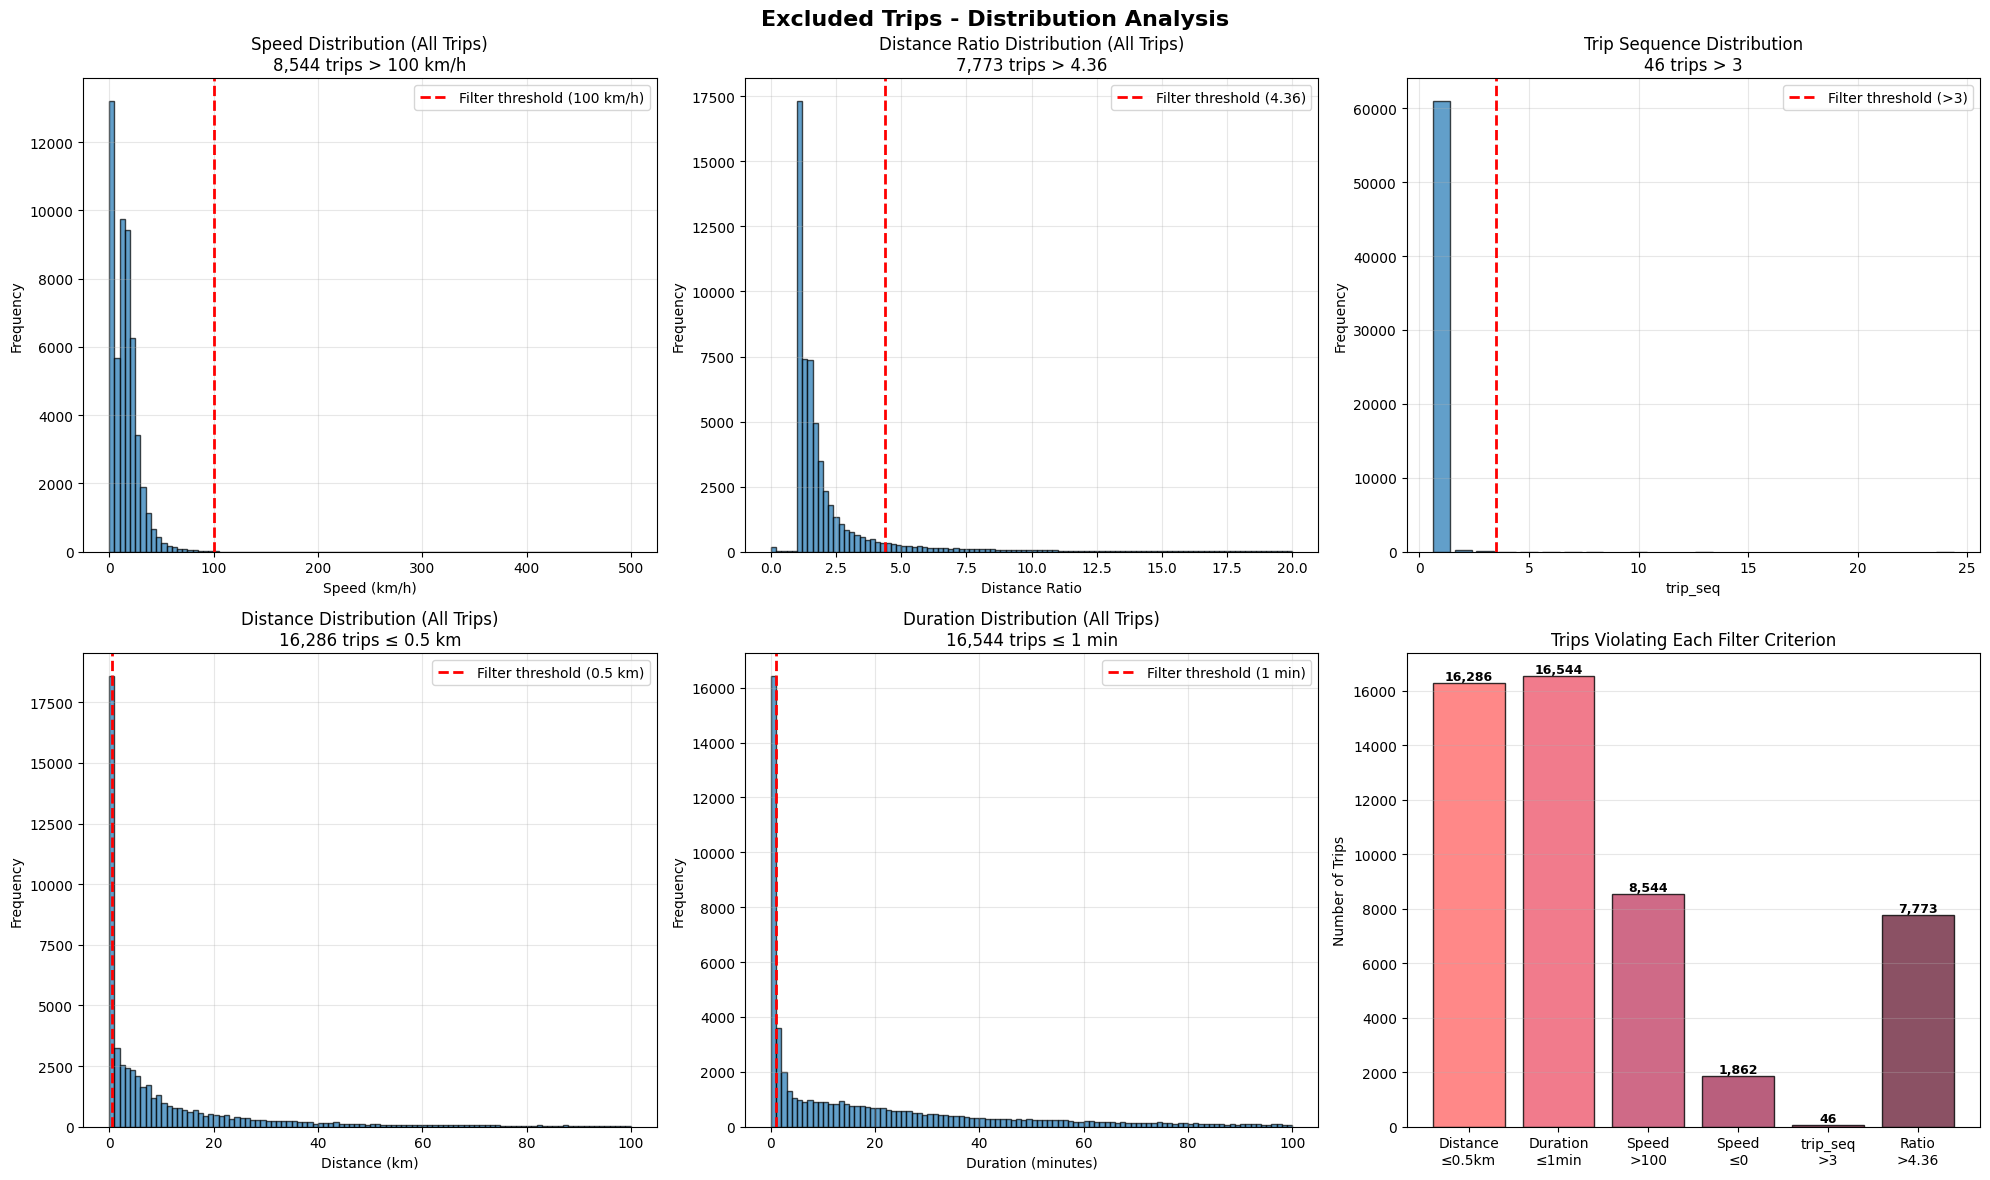

In [17]:
# VISUALIZATIONS OF EXCLUDED DATA
# =================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Excluded Trips - Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Speed distribution (full range)
ax1 = axes[0, 0]
speed_data = df['avg_speed_kmh'].dropna()
speed_data = speed_data[speed_data < 500]  # Cap for visualization
ax1.hist(speed_data, bins=100, edgecolor='black', alpha=0.7)
ax1.axvline(100, color='red', linestyle='--', linewidth=2, label='Filter threshold (100 km/h)')
ax1.set_xlabel('Speed (km/h)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Speed Distribution (All Trips)\n{(df["avg_speed_kmh"] > 100).sum():,} trips > 100 km/h')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Distance ratio distribution
ax2 = axes[0, 1]
ratio_data = df['distance_ratio'].dropna()
ratio_data = ratio_data[(ratio_data > 0) & (ratio_data < 20)]  # Cap for visualization
ax2.hist(ratio_data, bins=100, edgecolor='black', alpha=0.7)
ax2.axvline(4.36, color='red', linestyle='--', linewidth=2, label='Filter threshold (4.36)')
ax2.set_xlabel('Distance Ratio')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Distance Ratio Distribution (All Trips)\n{(df["distance_ratio"] > 4.36).sum():,} trips > 4.36')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Trip sequence distribution
ax3 = axes[0, 2]
seq_counts = df['trip_seq'].value_counts().sort_index().head(20)
ax3.bar(seq_counts.index, seq_counts.values, edgecolor='black', alpha=0.7)
ax3.axvline(3.5, color='red', linestyle='--', linewidth=2, label='Filter threshold (>3)')
ax3.set_xlabel('trip_seq')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Trip Sequence Distribution\n{(df["trip_seq"] > 3).sum():,} trips > 3')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Distance distribution
ax4 = axes[1, 0]
dist_data = df['distance'].dropna()
dist_data = dist_data[dist_data < 100]  # Cap for visualization
ax4.hist(dist_data, bins=100, edgecolor='black', alpha=0.7)
ax4.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Filter threshold (0.5 km)')
ax4.set_xlabel('Distance (km)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Distance Distribution (All Trips)\n{(df["distance"] <= 0.5).sum():,} trips ≤ 0.5 km')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Duration distribution
ax5 = axes[1, 1]
dur_data = df['trip_duration_minutes'].dropna()
dur_data = dur_data[(dur_data > -10) & (dur_data < 100)]  # Cap for visualization
ax5.hist(dur_data, bins=100, edgecolor='black', alpha=0.7)
ax5.axvline(1, color='red', linestyle='--', linewidth=2, label='Filter threshold (1 min)')
ax5.set_xlabel('Duration (minutes)')
ax5.set_ylabel('Frequency')
ax5.set_title(f'Duration Distribution (All Trips)\n{(df["trip_duration_minutes"] <= 1).sum():,} trips ≤ 1 min')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Excluded trips by category
ax6 = axes[1, 2]
categories = ['Distance\n≤0.5km', 'Duration\n≤1min', 'Speed\n>100', 'Speed\n≤0', 'trip_seq\n>3', 'Ratio\n>4.36']
counts = [
    (df['distance'] <= 0.5).sum(),
    (df['trip_duration_minutes'] <= 1).sum(),
    (df['avg_speed_kmh'] > 100).sum(),
    ((df['avg_speed_kmh'] <= 0) | df['avg_speed_kmh'].isna()).sum(),
    (df['trip_seq'] > 3).sum(),
    (df['distance_ratio'] > 4.36).sum()
]
colors = ['#ff6b6b', '#ee5a6f', '#c44569', '#a8375c', '#8b2f4d', '#6e263d']
bars = ax6.bar(categories, counts, color=colors, edgecolor='black', alpha=0.8)
ax6.set_ylabel('Number of Trips')
ax6.set_title('Trips Violating Each Filter Criterion')
ax6.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [18]:
# DETAILED ANALYSIS: SDK FILTER BYPASS CASES
# ============================================
# Focus on trips that SHOULD have been filtered by SDK

print("=" * 100)
print(" " * 25 + "⚠️ SDK FILTER BYPASS ANALYSIS (HIGH PRIORITY)")
print("=" * 100)

# Trips that should have been filtered by SDK (distance AND duration)
sdk_bypass = df[
    ((df['distance'] <= 0.5) | (df['trip_duration_minutes'] <= 1))
].copy()

print(f"\n📊 Trips that should have been filtered by SDK: {len(sdk_bypass):,}")
print(f"   • Distance ≤ 0.5 km only: {((df['distance'] <= 0.5) & (df['trip_duration_minutes'] > 1)).sum():,}")
print(f"   • Duration ≤ 1 min only: {((df['distance'] > 0.5) & (df['trip_duration_minutes'] <= 1)).sum():,}")
print(f"   • Both violations: {((df['distance'] <= 0.5) & (df['trip_duration_minutes'] <= 1)).sum():,}")

# Analyze patterns
if len(sdk_bypass) > 0:
    print(f"\n📅 Temporal Distribution:")
    sdk_bypass['created_date'] = pd.to_datetime(sdk_bypass['created_date_time']).dt.date
    daily_counts = sdk_bypass.groupby('created_date').size().sort_index()
    print(f"   • First occurrence: {daily_counts.index.min()}")
    print(f"   • Last occurrence: {daily_counts.index.max()}")
    print(f"   • Daily average: {daily_counts.mean():.1f} trips")
    print(f"   • Peak day: {daily_counts.idxmax()} ({daily_counts.max():,} trips)")
    
    print(f"\n👥 User Distribution:")
    user_counts = sdk_bypass.groupby('user_id').size().sort_values(ascending=False)
    print(f"   • Unique users affected: {len(user_counts):,}")
    print(f"   • Users with >10 such trips: {(user_counts > 10).sum():,}")
    print(f"   • Users with >50 such trips: {(user_counts > 50).sum():,}")
    
    print(f"\n🔝 Top 10 Users with SDK Bypass Trips:")
    for idx, (user_id, count) in enumerate(user_counts.head(10).items(), 1):
        user_trips = sdk_bypass[sdk_bypass['user_id'] == user_id]
        print(f"   {idx:2d}. User {user_id:6d}: {count:4d} trips | "
              f"Avg dist: {user_trips['distance'].mean():5.2f} km | "
              f"Avg dur: {user_trips['trip_duration_minutes'].mean():5.2f} min")
    
    # Statistical characteristics
    print(f"\n📊 Statistical Characteristics of SDK Bypass Trips:")
    print(f"   Distance (km):")
    print(f"      Min: {sdk_bypass['distance'].min():.3f} | Max: {sdk_bypass['distance'].max():.3f} | Mean: {sdk_bypass['distance'].mean():.3f}")
    print(f"   Duration (min):")
    print(f"      Min: {sdk_bypass['trip_duration_minutes'].min():.3f} | Max: {sdk_bypass['trip_duration_minutes'].max():.3f} | Mean: {sdk_bypass['trip_duration_minutes'].mean():.3f}")
    print(f"   Negative durations: {(sdk_bypass['trip_duration_minutes'] < 0).sum():,}")
    print(f"   Zero distance: {(sdk_bypass['distance'] == 0).sum():,}")

print("\n" + "=" * 100)
print("💡 RECOMMENDATION: Review SDK validation logic and backend acceptance criteria")
print("=" * 100)

                         ⚠️ SDK FILTER BYPASS ANALYSIS (HIGH PRIORITY)

📊 Trips that should have been filtered by SDK: 23,954
   • Distance ≤ 0.5 km only: 7,410
   • Duration ≤ 1 min only: 7,668
   • Both violations: 8,876

📅 Temporal Distribution:
   • First occurrence: 2024-12-20
   • Last occurrence: 2025-12-14
   • Daily average: 67.3 trips
   • Peak day: 2025-09-30 (1,920 trips)

👥 User Distribution:
   • Unique users affected: 801
   • Users with >10 such trips: 543
   • Users with >50 such trips: 79

🔝 Top 10 Users with SDK Bypass Trips:
    1. User 186245: 2224 trips | Avg dist:  0.09 km | Avg dur:  0.43 min
    2. User   1831:  599 trips | Avg dist:  0.18 km | Avg dur:  1.44 min
    3. User 183187:  534 trips | Avg dist:  0.05 km | Avg dur:  4.96 min
    4. User   1666:  422 trips | Avg dist:  0.03 km | Avg dur:  0.96 min
    5. User 188781:  269 trips | Avg dist:  0.07 km | Avg dur:  1.05 min
    6. User 182701:  267 trips | Avg dist:  0.13 km | Avg dur:  1.89 min
    7. User

In [ ]:
# EXPORT EXTREME HIGH-VALUE OUTLIERS FOR DETAILED INVESTIGATION
# ================================================================

import os

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

from datetime import datetime
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("=" * 100)
print(" " * 25 + "📁 EXPORTING EXTREME HIGH-VALUE OUTLIERS")
print("=" * 100)

# Export extreme speed outliers (> 100 km/h, especially > 1000 km/h)
extreme_speed_file = f'{output_dir}/extreme_high_speed_over100kmh_{export_timestamp}.csv'
extreme_high_speed.to_csv(extreme_speed_file, index=False)
print(f"\n✅ Extreme HIGH SPEED outliers (> 100 km/h):")
print(f"   📂 File: {extreme_speed_file}")
print(f"   📊 Records: {len(extreme_high_speed):,} trips")
print(f"   💾 Size: {os.path.getsize(extreme_speed_file) / 1024:.1f} KB")

very_extreme_speed_file = f'{output_dir}/very_extreme_speed_over1000kmh_{export_timestamp}.csv'
very_extreme_speed.to_csv(very_extreme_speed_file, index=False)
print(f"\n✅ VERY EXTREME SPEED outliers (> 1000 km/h - data errors):")
print(f"   📂 File: {very_extreme_speed_file}")
print(f"   📊 Records: {len(very_extreme_speed):,} trips")
print(f"   💾 Size: {os.path.getsize(very_extreme_speed_file) / 1024:.1f} KB")

# Export extreme distance ratio outliers (> 4.36, especially > 20)
extreme_ratio_file = f'{output_dir}/extreme_distance_ratio_over4.36_{export_timestamp}.csv'
extreme_ratio.to_csv(extreme_ratio_file, index=False)
print(f"\n✅ Extreme DISTANCE RATIO outliers (> 4.36):")
print(f"   📂 File: {extreme_ratio_file}")
print(f"   📊 Records: {len(extreme_ratio):,} trips")
print(f"   💾 Size: {os.path.getsize(extreme_ratio_file) / 1024:.1f} KB")

very_extreme_ratio_file = f'{output_dir}/very_extreme_ratio_over20_{export_timestamp}.csv'
very_extreme_ratio.to_csv(very_extreme_ratio_file, index=False)
print(f"\n✅ VERY EXTREME RATIO outliers (> 20 - GPS/route errors):")
print(f"   📂 File: {very_extreme_ratio_file}")
print(f"   📊 Records: {len(very_extreme_ratio):,} trips")
print(f"   💾 Size: {os.path.getsize(very_extreme_ratio_file) / 1024:.1f} KB")

# Export extreme trip_seq outliers (> 3, especially > 10)
extreme_seq_file = f'{output_dir}/extreme_trip_seq_over3_{export_timestamp}.csv'
extreme_seq.to_csv(extreme_seq_file, index=False)
print(f"\n✅ Extreme TRIP_SEQ outliers (> 3):")
print(f"   📂 File: {extreme_seq_file}")
print(f"   📊 Records: {len(extreme_seq):,} trips")
print(f"   💾 Size: {os.path.getsize(extreme_seq_file) / 1024:.1f} KB")

very_extreme_seq_file = f'{output_dir}/very_extreme_seq_over10_{export_timestamp}.csv'
very_extreme_seq.to_csv(very_extreme_seq_file, index=False)
print(f"\n✅ VERY EXTREME TRIP_SEQ outliers (> 10 - booking issues):")
print(f"   📂 File: {very_extreme_seq_file}")
print(f"   📊 Records: {len(very_extreme_seq):,} trips")
print(f"   💾 Size: {os.path.getsize(very_extreme_seq_file) / 1024:.1f} KB")

# Summary report
print(f"\n" + "=" * 100)
print("📋 EXPORT SUMMARY - EXTREME HIGH-VALUE OUTLIERS")
print("=" * 100)
print(f"\nThese trips have EXTREME values and warrant investigation:")
print(f"  1. Speed > 100 km/h ({len(extreme_high_speed):,} trips)")
print(f"     - VERY EXTREME: > 1000 km/h ({len(very_extreme_speed):,} trips) - likely data errors")
print(f"  2. Distance Ratio > 4.36 ({len(extreme_ratio):,} trips)")
print(f"     - VERY EXTREME: > 20 ({len(very_extreme_ratio):,} trips) - GPS/route errors")
print(f"  3. trip_seq > 3 ({len(extreme_seq):,} trips)")
print(f"     - VERY EXTREME: > 10 ({len(very_extreme_seq):,} trips) - booking system issues")
print(f"\n💡 Investigation Focus:")
print(f"  • Speed > 1000 km/h = Clear data quality issues (GPS jumping, timestamp errors)")
print(f"  • Ratio > 20 = Severe GPS drift or incorrect route recording")
print(f"  • trip_seq > 10 = Unusual booking patterns, system retries, or fraud indicators")
print("\n" + "=" * 100)

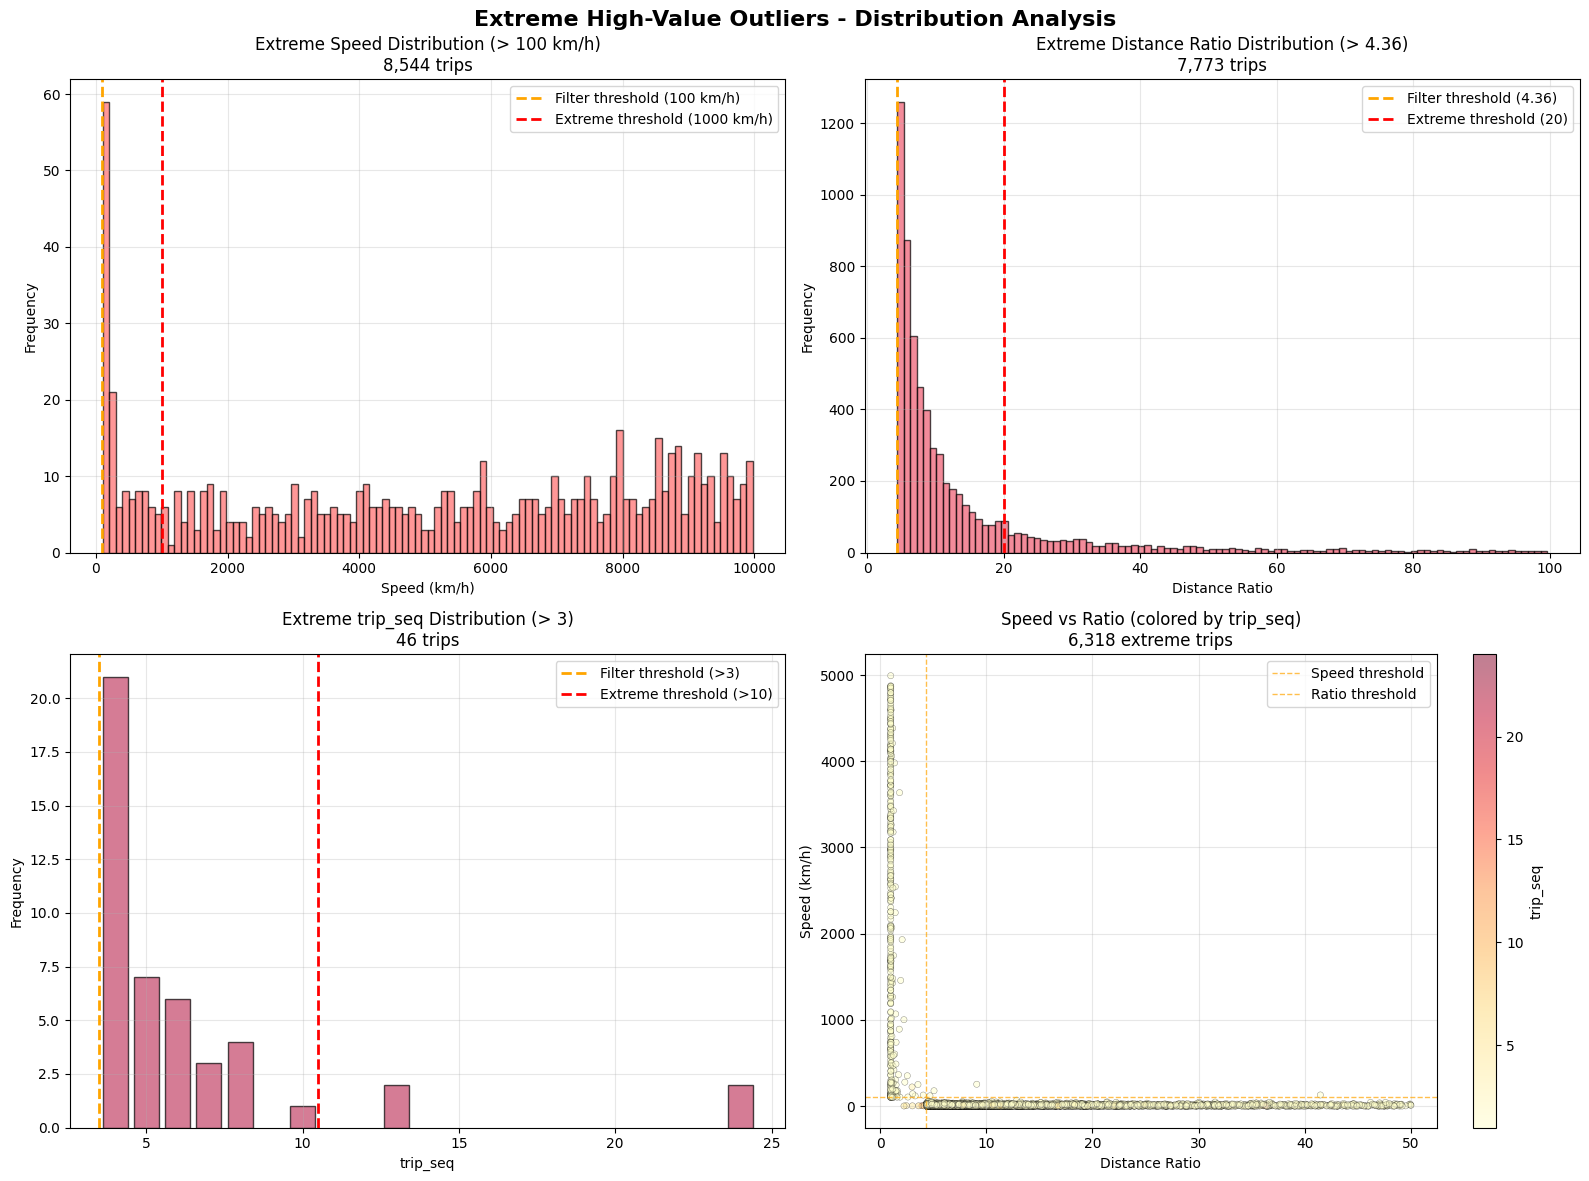


✅ Visualization complete!


In [28]:
# VISUALIZATION: EXTREME HIGH-VALUE OUTLIERS ANALYSIS
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Extreme High-Value Outliers - Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Speed distribution for trips > 100 km/h (focus on extremes)
ax1 = axes[0, 0]
speed_extreme = extreme_high_speed['avg_speed_kmh'].dropna()
speed_extreme_capped = speed_extreme[speed_extreme < 10000]  # Cap for visualization
ax1.hist(speed_extreme_capped, bins=100, edgecolor='black', alpha=0.7, color='#ff6b6b')
ax1.axvline(100, color='orange', linestyle='--', linewidth=2, label='Filter threshold (100 km/h)')
ax1.axvline(1000, color='red', linestyle='--', linewidth=2, label='Extreme threshold (1000 km/h)')
ax1.set_xlabel('Speed (km/h)')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Extreme Speed Distribution (> 100 km/h)\n{len(extreme_high_speed):,} trips')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Distance ratio distribution for trips > 4.36
ax2 = axes[0, 1]
ratio_extreme = extreme_ratio['distance_ratio'].dropna()
ratio_extreme_capped = ratio_extreme[ratio_extreme < 100]  # Cap for visualization
ax2.hist(ratio_extreme_capped, bins=100, edgecolor='black', alpha=0.7, color='#ee5a6f')
ax2.axvline(4.36, color='orange', linestyle='--', linewidth=2, label='Filter threshold (4.36)')
ax2.axvline(20, color='red', linestyle='--', linewidth=2, label='Extreme threshold (20)')
ax2.set_xlabel('Distance Ratio')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Extreme Distance Ratio Distribution (> 4.36)\n{len(extreme_ratio):,} trips')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Trip sequence distribution for trips > 3
ax3 = axes[1, 0]
seq_extreme = extreme_seq['trip_seq'].value_counts().sort_index().head(30)
ax3.bar(seq_extreme.index, seq_extreme.values, edgecolor='black', alpha=0.7, color='#c44569')
ax3.axvline(3.5, color='orange', linestyle='--', linewidth=2, label='Filter threshold (>3)')
ax3.axvline(10.5, color='red', linestyle='--', linewidth=2, label='Extreme threshold (>10)')
ax3.set_xlabel('trip_seq')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Extreme trip_seq Distribution (> 3)\n{len(extreme_seq):,} trips')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Scatter plot: Speed vs Distance Ratio (colored by trip_seq)
ax4 = axes[1, 1]
# Create combined extreme dataset
extreme_combined = df[
    ((df['avg_speed_kmh'] > 100) | (df['distance_ratio'] > 4.36) | (df['trip_seq'] > 3))
].copy()

# Cap for visualization
extreme_plot = extreme_combined[
    (extreme_combined['avg_speed_kmh'] < 5000) & 
    (extreme_combined['distance_ratio'] < 50)
].copy()

scatter = ax4.scatter(
    extreme_plot['distance_ratio'], 
    extreme_plot['avg_speed_kmh'], 
    c=extreme_plot['trip_seq'],
    cmap='YlOrRd',
    alpha=0.5,
    s=20,
    edgecolors='black',
    linewidth=0.3
)
ax4.axhline(100, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Speed threshold')
ax4.axvline(4.36, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Ratio threshold')
ax4.set_xlabel('Distance Ratio')
ax4.set_ylabel('Speed (km/h)')
ax4.set_title(f'Speed vs Ratio (colored by trip_seq)\n{len(extreme_plot):,} extreme trips')
ax4.legend()
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='trip_seq')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

In [27]:
# OUTLIER ANALYSIS: EXTREME TRIP SEQUENCE (>> 3)
# ================================================

print("=" * 100)
print(" " * 25 + "🔢 EXTREME TRIP SEQUENCE - DISTRIBUTION ANALYSIS")
print("=" * 100)

# Focus on trips with VERY high trip_seq (significantly > 3)
extreme_seq = df[df['trip_seq'] > 3].copy()

print(f"\n📊 Total trips with trip_seq > 3: {len(extreme_seq):,}")
print(f"   Percentage of all trips: {len(extreme_seq)/len(df)*100:.2f}%")

# Analyze distribution of extreme trip_seq
print(f"\n📈 Trip Sequence Distribution (trip_seq > 3):")
print(extreme_seq['trip_seq'].describe(percentiles=[.10, .25, .50, .75, .90, .95, .99]))

# Show value counts for extreme trip_seq
print(f"\n📊 Breakdown by trip_seq value (top 20):")
print(extreme_seq['trip_seq'].value_counts().sort_index().head(20))

# Identify VERY extreme outliers - ridiculously high sequences
very_extreme_seq = extreme_seq[extreme_seq['trip_seq'] > 10]
print(f"\n🔍 VERY EXTREME OUTLIERS (trip_seq > 10 - unusual booking patterns):")
print(f"   Count: {len(very_extreme_seq):,} trips ({len(very_extreme_seq)/len(extreme_seq)*100:.1f}% of high seq trips)")
if len(very_extreme_seq) > 0:
    print(f"   trip_seq range: {very_extreme_seq['trip_seq'].min():.0f} - {very_extreme_seq['trip_seq'].max():.0f}")
    print(f"   Mean trip_seq: {very_extreme_seq['trip_seq'].mean():.2f}")
    print(f"   Mean distance: {very_extreme_seq['distance'].mean():.2f} km")
    print(f"   Mean duration: {very_extreme_seq['trip_duration_minutes'].mean():.2f} min")
    print(f"   Unique users: {very_extreme_seq['user_id'].nunique():,}")

# Cross-check: are these also problematic in other ways?
print(f"\n🔗 Cross-Analysis with Other Metrics:")
print(f"   • trip_seq > 3 AND Speed > 100 km/h: {((extreme_seq['avg_speed_kmh'] > 100)).sum():,}")
print(f"   • trip_seq > 3 AND Ratio > 4.36: {((extreme_seq['distance_ratio'] > 4.36)).sum():,}")
print(f"   • trip_seq > 3 AND Distance > 0.5 km: {((extreme_seq['distance'] > 0.5)).sum():,}")

# User analysis for extreme trip_seq
print(f"\n👥 User Analysis:")
user_extreme_seq = extreme_seq.groupby('user_id').size().sort_values(ascending=False)
print(f"   Unique users: {len(user_extreme_seq):,}")
print(f"   Users with >10 such trips: {(user_extreme_seq > 10).sum():,}")
print(f"   Users with >50 such trips: {(user_extreme_seq > 50).sum():,}")

print(f"\n🔝 Top 10 Users with Extreme trip_seq:")
for idx, (user_id, count) in enumerate(user_extreme_seq.head(10).items(), 1):
    user_trips = extreme_seq[extreme_seq['user_id'] == user_id]
    print(f"   {idx:2d}. User {user_id:6d}: {count:3d} trips | "
          f"Avg seq: {user_trips['trip_seq'].mean():5.1f} | "
          f"Max seq: {user_trips['trip_seq'].max():.0f} | "
          f"Avg dist: {user_trips['distance'].mean():6.2f} km")

# Show sample of EXTREME trip_seq outliers
print(f"\n📋 Top 20 EXTREME trip_seq Outliers (highest sequences):")
if len(extreme_seq) > 0:
    sample = extreme_seq.nlargest(20, 'trip_seq')[['trip_id', 'user_id', 'trip_seq', 'distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_ratio']]
    print(sample.to_string(index=False))

print("\n" + "=" * 100)

                         🔢 EXTREME TRIP SEQUENCE - DISTRIBUTION ANALYSIS

📊 Total trips with trip_seq > 3: 46
   Percentage of all trips: 0.07%

📈 Trip Sequence Distribution (trip_seq > 3):
count    46.000000
mean      6.347826
std       4.387950
min       4.000000
10%       4.000000
25%       4.000000
50%       5.000000
75%       6.750000
90%       9.000000
95%      13.000000
99%      24.000000
max      24.000000
Name: trip_seq, dtype: float64

📊 Breakdown by trip_seq value (top 20):
trip_seq
4     21
5      7
6      6
7      3
8      4
10     1
13     2
24     2
Name: count, dtype: int64

🔍 VERY EXTREME OUTLIERS (trip_seq > 10 - unusual booking patterns):
   Count: 4 trips (8.7% of high seq trips)
   trip_seq range: 13 - 24
   Mean trip_seq: 18.50
   Mean distance: 521.38 km
   Mean duration: 6426.62 min
   Unique users: 3

🔗 Cross-Analysis with Other Metrics:
   • trip_seq > 3 AND Speed > 100 km/h: 0
   • trip_seq > 3 AND Ratio > 4.36: 40
   • trip_seq > 3 AND Distance > 0.5 km: 45


In [29]:
# CHECK IF trip_score COLUMN EXISTS
# ====================================

print("=" * 100)
print(" " * 30 + "🔍 CHECKING FOR trip_score COLUMN")
print("=" * 100)

print(f"\n📋 Current DataFrame Columns ({len(df.columns)} total):")
print(df.columns.tolist())

if 'trip_score' in df.columns:
    print(f"\n✅ trip_score column EXISTS in current dataframe")
    print(f"   • Non-null values: {df['trip_score'].notna().sum():,}")
    print(f"   • Null values: {df['trip_score'].isna().sum():,}")
else:
    print(f"\n❌ trip_score column NOT FOUND in current dataframe")
    print(f"   Need to reload CSV to get trip_score column")
    
print("\n" + "=" * 100)

                              🔍 CHECKING FOR trip_score COLUMN

📋 Current DataFrame Columns (46 total):
['trip_id', 'user_id', 'vehicle_id', 'device_id', 'latitude_from', 'longitude_from', 'latitude_to', 'longitude_to', 'driving_date_from', 'driving_date_to', 'driving_year_month', 'distance', 'driving_time', 'normal_start_count', 'normal_stop_count', 'normal_acceleration_count', 'normal_deceleration_count', 'sudden_start_count', 'sudden_stop_count', 'sudden_acceleration_count', 'sudden_deceleration_count', 'trip_point', 'trip_seq', 'eot', 'ets', 'raw_data_create_date', 'trip_safety_score', 'trip_grade', 'remark', 'created_date_time', 'created_by', 'last_updated_date_time', 'last_updated_by', 'RecordDate', 'distance_haversine', 'trip_duration_seconds', 'trip_duration_minutes', 'distance_diff_km', 'distance_ratio', 'avg_speed_kmh', 'avg_speed_kmh_alt', 'driving_time_minutes', 'duration_match', 'duration_diff_minutes', 'duration_diff_pct', 'speed_match']

❌ trip_score column NOT FOUND in 

In [26]:
# OUTLIER ANALYSIS: EXTREME DISTANCE RATIOS (>> 4.36)
# ======================================================

print("=" * 100)
print(" " * 25 + "🗺️ EXTREME DISTANCE RATIO TRIPS - DISTRIBUTION ANALYSIS")
print("=" * 100)

# Focus on trips with VERY extreme distance ratios (significantly > 4.36)
extreme_ratio = df[df['distance_ratio'] > 4.36].copy()

print(f"\n📊 Total trips with distance_ratio > 4.36: {len(extreme_ratio):,}")
print(f"   Percentage of all trips: {len(extreme_ratio)/len(df)*100:.2f}%")

# Analyze distribution of extreme ratios
print(f"\n📈 Distance Ratio Distribution (trips > 4.36):")
print(extreme_ratio['distance_ratio'].describe(percentiles=[.10, .25, .50, .75, .90, .95, .99]))

# Categorize by ratio ranges
ratio_bins = [4.36, 5, 10, 20, 50, 100, np.inf]
ratio_labels = ['4.36-5', '5-10', '10-20', '20-50', '50-100', '>100']
extreme_ratio['ratio_range'] = pd.cut(extreme_ratio['distance_ratio'], bins=ratio_bins, labels=ratio_labels, include_lowest=True)

print(f"\n📊 Breakdown by distance ratio range:")
print(extreme_ratio['ratio_range'].value_counts().sort_index())

# Identify EXTREME outliers - ridiculously high ratios
very_extreme_ratio = extreme_ratio[extreme_ratio['distance_ratio'] > 20]
print(f"\n🔍 VERY EXTREME OUTLIERS (ratio > 20 - clearly GPS/route errors):")
print(f"   Count: {len(very_extreme_ratio):,} trips ({len(very_extreme_ratio)/len(extreme_ratio)*100:.1f}% of high ratio trips)")
if len(very_extreme_ratio) > 0:
    print(f"   Ratio range: {very_extreme_ratio['distance_ratio'].min():.2f} - {very_extreme_ratio['distance_ratio'].max():.2f}")
    print(f"   Mean recorded distance: {very_extreme_ratio['distance'].mean():.2f} km")
    print(f"   Mean straight-line distance: {very_extreme_ratio['distance_haversine'].mean():.2f} km")
    print(f"   Mean detour: {very_extreme_ratio['distance_diff_km'].mean():.2f} km")
    print(f"   Unique users: {very_extreme_ratio['user_id'].nunique():,}")

# Cross-check: are these also short trips?
print(f"\n🔗 Cross-Analysis with Distance/Duration:")
print(f"   • Ratio > 4.36 AND Distance > 0.5 km: {((extreme_ratio['distance'] > 0.5)).sum():,}")
print(f"   • Ratio > 4.36 AND Duration > 1 min: {((extreme_ratio['trip_duration_minutes'] > 1)).sum():,}")
print(f"   • Ratio > 4.36 BUT very short trips (dist ≤ 1 km): {((extreme_ratio['distance'] <= 1.0)).sum():,}")

# Show sample of EXTREME ratio outliers
print(f"\n📋 Top 20 EXTREME Distance Ratio Outliers (highest ratios):")
if len(extreme_ratio) > 0:
    sample = extreme_ratio.nlargest(20, 'distance_ratio')[['trip_id', 'user_id', 'distance', 'distance_haversine', 'distance_ratio', 'trip_duration_minutes', 'avg_speed_kmh', 'trip_seq']]
    print(sample.to_string(index=False))

print("\n" + "=" * 100)

                         🗺️ EXTREME DISTANCE RATIO TRIPS - DISTRIBUTION ANALYSIS

📊 Total trips with distance_ratio > 4.36: 7,773
   Percentage of all trips: 12.67%

📈 Distance Ratio Distribution (trips > 4.36):
count     7773.000000
mean       306.018658
std       1614.565178
min          4.360573
10%          4.888841
25%          6.032078
50%         10.062549
75%         31.445204
90%        441.133282
95%       1486.052964
99%       6031.319433
max      48333.080002
Name: distance_ratio, dtype: float64

📊 Breakdown by distance ratio range:
ratio_range
4.36-5     931
5-10      2946
10-20     1444
20-50      878
50-100     335
>100      1239
Name: count, dtype: int64

🔍 VERY EXTREME OUTLIERS (ratio > 20 - clearly GPS/route errors):
   Count: 2,452 trips (31.5% of high ratio trips)
   Ratio range: 20.01 - 48333.08
   Mean recorded distance: 64.03 km
   Mean straight-line distance: 1.50 km
   Mean detour: 62.53 km
   Unique users: 270

🔗 Cross-Analysis with Distance/Duration:
   • Rat

In [25]:
# OUTLIER ANALYSIS: EXTREME HIGH SPEED TRIPS (>> 100 km/h)
# ==========================================================

print("=" * 100)
print(" " * 25 + "🚀 EXTREME HIGH SPEED TRIPS - DISTRIBUTION ANALYSIS")
print("=" * 100)

# Focus on trips with VERY high speeds (not just >100, but significantly higher)
extreme_high_speed = df[df['avg_speed_kmh'] > 100].copy()

print(f"\n📊 Total trips with speed > 100 km/h: {len(extreme_high_speed):,}")
print(f"   Percentage of all trips: {len(extreme_high_speed)/len(df)*100:.2f}%")

# Analyze distribution of extreme speeds
print(f"\n📈 Speed Distribution (trips > 100 km/h):")
print(extreme_high_speed['avg_speed_kmh'].describe(percentiles=[.10, .25, .50, .75, .90, .95, .99]))

# Categorize by speed ranges
speed_bins = [100, 200, 500, 1000, 5000, 10000, np.inf]
speed_labels = ['100-200', '200-500', '500-1K', '1K-5K', '5K-10K', '>10K km/h']
extreme_high_speed['speed_range'] = pd.cut(extreme_high_speed['avg_speed_kmh'], bins=speed_bins, labels=speed_labels, include_lowest=True)

print(f"\n📊 Breakdown by speed range:")
print(extreme_high_speed['speed_range'].value_counts().sort_index())

# Identify EXTREME outliers - ridiculously high speeds
very_extreme_speed = extreme_high_speed[extreme_high_speed['avg_speed_kmh'] > 1000]
print(f"\n🔍 VERY EXTREME OUTLIERS (> 1000 km/h - clearly data errors):")
print(f"   Count: {len(very_extreme_speed):,} trips ({len(very_extreme_speed)/len(extreme_high_speed)*100:.1f}% of high speed trips)")
if len(very_extreme_speed) > 0:
    print(f"   Speed range: {very_extreme_speed['avg_speed_kmh'].min():.1f} - {very_extreme_speed['avg_speed_kmh'].max():.1f} km/h")
    print(f"   Mean distance: {very_extreme_speed['distance'].mean():.2f} km")
    print(f"   Mean duration: {very_extreme_speed['trip_duration_minutes'].mean():.2f} min")
    print(f"   Unique users: {very_extreme_speed['user_id'].nunique():,}")

# Cross-check: are these also short trips?
print(f"\n🔗 Cross-Analysis with Distance/Duration:")
print(f"   • Speed > 100 km/h AND Distance > 0.5 km: {((extreme_high_speed['distance'] > 0.5)).sum():,}")
print(f"   • Speed > 100 km/h AND Duration > 1 min: {((extreme_high_speed['trip_duration_minutes'] > 1)).sum():,}")
print(f"   • Speed > 100 km/h BUT Distance ≤ 0.5 km: {((extreme_high_speed['distance'] <= 0.5)).sum():,}")

# Show sample of EXTREME speed outliers
print(f"\n📋 Top 20 EXTREME Speed Outliers (highest speeds):")
if len(extreme_high_speed) > 0:
    sample = extreme_high_speed.nlargest(20, 'avg_speed_kmh')[['trip_id', 'user_id', 'distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_ratio', 'trip_seq']]
    print(sample.to_string(index=False))

print("\n" + "=" * 100)

                         🚀 EXTREME HIGH SPEED TRIPS - DISTRIBUTION ANALYSIS

📊 Total trips with speed > 100 km/h: 8,544
   Percentage of all trips: 13.93%

📈 Speed Distribution (trips > 100 km/h):
count    8.544000e+03
mean     9.521122e+04
std      1.120256e+05
min      1.009307e+02
10%      1.117991e+04
25%      2.378767e+04
50%      5.791679e+04
75%      1.262712e+05
90%      2.367552e+05
95%      3.059546e+05
99%      4.646390e+05
max      2.869562e+06
Name: avg_speed_kmh, dtype: float64

📊 Breakdown by speed range:
speed_range
100-200        59
200-500        36
500-1K         33
1K-5K         224
5K-10K        389
>10K km/h    7803
Name: count, dtype: int64

🔍 VERY EXTREME OUTLIERS (> 1000 km/h - clearly data errors):
   Count: 8,416 trips (98.5% of high speed trips)
   Speed range: 1002.2 - 2869562.0 km/h
   Mean distance: 505.85 km
   Mean duration: 0.52 min
   Unique users: 442

🔗 Cross-Analysis with Distance/Duration:
   • Speed > 100 km/h AND Distance > 0.5 km: 8,524
   • Sp

## 🔬 Deep Dive: High-Value Outliers Analysis

This section explores trips with **extreme high values** that make them outliers - NOT the short distance/duration trips, but rather:
- **Very high speeds** (significantly > 100 km/h)
- **Extreme distance ratios** (significantly > 4.36)
- **Very high trip_seq** (significantly > 3)

These are trips that passed SDK filters but have suspicious extreme values in other metrics.

In [19]:
# EXPORT TRIP IDs FOR INVESTIGATION
# ====================================

import os

# Create output directory if it doesn't exist
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

# Add a timestamp for the export
from datetime import datetime
export_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("=" * 100)
print(" " * 30 + "📋 EXPORTING TRIP IDs FOR INVESTIGATION")
print("=" * 100)

# Define exclusion categories with descriptions
exclusion_categories = {
    'short_distance': {
        'condition': df['distance'] <= 0.5,
        'description': 'Distance ≤ 0.5 km (SDK should filter these)',
        'priority': 'HIGH'
    },
    'short_duration': {
        'condition': df['trip_duration_minutes'] <= 1,
        'description': 'Duration ≤ 1 min (SDK should filter these)',
        'priority': 'HIGH'
    },
    'high_speed': {
        'condition': df['avg_speed_kmh'] > 100,
        'description': 'Speed > 100 km/h (GPS errors or data quality)',
        'priority': 'MEDIUM'
    },
    'invalid_speed': {
        'condition': (df['avg_speed_kmh'] <= 0) | df['avg_speed_kmh'].isna(),
        'description': 'Speed ≤ 0 or NaN (missing/invalid data)',
        'priority': 'MEDIUM'
    },
    'high_trip_seq': {
        'condition': df['trip_seq'] > 3,
        'description': 'trip_seq > 3 (booking/system behavior)',
        'priority': 'LOW'
    },
    'high_distance_ratio': {
        'condition': df['distance_ratio'] > 4.36,
        'description': 'Distance ratio > 4.36 (extreme detours)',
        'priority': 'LOW'
    }
}

# Export trip IDs for each category
print("\n📊 Exporting trip IDs by exclusion category:\n")

summary_data = []

for category_name, category_info in exclusion_categories.items():
    trips_in_category = df[category_info['condition']].copy()
    
    if len(trips_in_category) > 0:
        # Select key columns for investigation
        investigation_data = trips_in_category[[
            'trip_id', 'user_id', 'created_date_time',
            'distance', 'distance_haversine', 'distance_ratio',
            'trip_duration_minutes', 'avg_speed_kmh', 'trip_seq',
            'latitude_from', 'longitude_from', 'latitude_to', 'longitude_to'
        ]].copy()
        
        # Export to CSV
        filename = f'{output_dir}/investigation_{category_name}_{export_timestamp}.csv'
        investigation_data.to_csv(filename, index=False)
        
        print(f"  ✓ {category_info['priority']:6s} | {category_info['description']:50s} | {len(trips_in_category):6,} trips → {os.path.basename(filename)}")
        
        # Collect summary data
        summary_data.append({
            'Category': category_name,
            'Description': category_info['description'],
            'Priority': category_info['priority'],
            'Trip Count': len(trips_in_category),
            'Unique Users': trips_in_category['user_id'].nunique(),
            'Filename': os.path.basename(filename)
        })

# Create summary table
print("\n" + "=" * 100)
print("📋 INVESTIGATION FILES SUMMARY")
print("=" * 100)

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Export summary table
summary_file = f'{output_dir}/investigation_summary_{export_timestamp}.csv'
summary_df.to_csv(summary_file, index=False)
print(f"\n✅ Summary table saved: {summary_file}")

print("\n" + "=" * 100)

                              📋 EXPORTING TRIP IDs FOR INVESTIGATION

📊 Exporting trip IDs by exclusion category:

  ✓ HIGH   | Distance ≤ 0.5 km (SDK should filter these)        | 16,286 trips → investigation_short_distance_20251223_084426.csv
  ✓ HIGH   | Duration ≤ 1 min (SDK should filter these)         | 16,544 trips → investigation_short_duration_20251223_084426.csv
  ✓ MEDIUM | Speed > 100 km/h (GPS errors or data quality)      |  8,544 trips → investigation_high_speed_20251223_084426.csv
  ✓ MEDIUM | Speed ≤ 0 or NaN (missing/invalid data)            |  1,862 trips → investigation_invalid_speed_20251223_084426.csv
  ✓ LOW    | trip_seq > 3 (booking/system behavior)             |     46 trips → investigation_high_trip_seq_20251223_084426.csv
  ✓ LOW    | Distance ratio > 4.36 (extreme detours)            |  7,773 trips → investigation_high_distance_ratio_20251223_084426.csv

📋 INVESTIGATION FILES SUMMARY

           Category                                   Description Priority

## 📝 Conclusions & Insights

### Key Findings by Exclusion Category

#### 1. **Distance ≤ 0.5 km & Duration ≤ 1 min** ⚠️ **DATA QUALITY CONCERN**
These trips **should not be recorded** in the database if SDK filters are working correctly. Their presence indicates:
- **Potential SDK filter bypass** - Trips are being sent despite SDK validation
- **Race conditions** - Trip started/ended too quickly for SDK to filter
- **Manual override** - Backend accepting trips that failed SDK validation
- **GPS initialization issues** - Distance calculated before GPS stabilized

**Recommendation**: Investigate SDK filter implementation and backend validation logic.

#### 2. **Speed > 100 km/h** 🚗
High-speed trips may indicate:
- **GPS jumping** - Inaccurate location updates creating false speed calculations
- **Tunnels/signal loss** - Location updates after long gaps
- **Data quality issues** - Incorrect timestamps or distances
- **Legitimate highway trips** - Some may be valid (rare)

**Action**: Review these trips individually to distinguish GPS errors from real high-speed travel.

#### 3. **Distance Ratio > 4.36** 🗺️
Extreme detour ratios suggest:
- **Incorrect route recording** - Actual path not captured properly
- **GPS drift** - Start/end points recorded incorrectly
- **Multiple stops** - Driver took detours not reflected in straight-line distance
- **Map matching errors** - Route snapping failed

**Action**: Analyze specific trips to identify common patterns and improve route tracking.

#### 4. **Trip Sequence > 3** 🔢
High sequence numbers indicate:
- **Booking/cancellation patterns** - Multiple attempts before successful trip
- **System retries** - Backend creating duplicate trip records
- **User behavior** - Frequent booking changes
- **Integration issues** - Multiple systems creating trip records

**Action**: Review trip_seq generation logic and booking flow to reduce unnecessary sequences.

#### 5. **Invalid Speed (≤ 0 or NaN)** ❌
Zero/negative speeds suggest:
- **Missing driving_time** - Calculation resulted in division by zero
- **Data pipeline issues** - Values not calculated or lost in ETL
- **Timestamp errors** - driving_time calculated incorrectly

**Action**: Ensure all required fields are populated before trip finalization.

---

### Priority Investigation Areas

1. **HIGH PRIORITY**: Distance ≤ 0.5 km and Duration ≤ 1 min
   - These violate SDK business rules
   - Indicate potential system bypass or validation failure
   
2. **MEDIUM PRIORITY**: Speed > 100 km/h and Invalid Speed
   - Data quality and calculation issues
   - Impact metrics and reporting accuracy
   
3. **LOW PRIORITY**: High trip_seq and Distance Ratio
   - Business logic and user behavior patterns
   - Less critical for immediate action

In [45]:
# Zero-Point Trips Analysis (Anomalous Data Only) - EXCLUDING USER 19307
# Filter out user 19307 (broken device with incorrect datetime) from the analysis
zero_point_anomalies = excluded_all[(excluded_all['trip_point'] == 0) & (excluded_all['user_id'] != 19307)]

print("\n" + "="*80)
print("ZERO-POINT ANOMALIES DETAILED ANALYSIS (USER 19307 EXCLUDED)")
print("="*80)

print(f"\nTotal Zero-Point Anomalies: {len(zero_point_anomalies):,}")
print(f"Unique Users: {zero_point_anomalies['user_id'].nunique():,}")

# Relevant columns for investigation
relevant_cols = ['trip_id', 'user_id', 'trip_point', 'trip_safety_score', 'trip_grade',
                 'distance', 'trip_duration_minutes', 'avg_speed_kmh', 'distance_ratio', 
                 'trip_seq', 'sudden_acceleration_count', 'sudden_braking_count', 
                 'sudden_left_turn_count', 'sudden_right_turn_count', 'created_date_time']

available_cols = [col for col in relevant_cols if col in zero_point_anomalies.columns]

print(f"\nSample of Zero-Point Anomalies (first 20):")
print(zero_point_anomalies[available_cols].head(20).to_string())

# User distribution
print(f"\n\nTop Users with Most Zero-Point Anomalies:")
top_users = zero_point_anomalies['user_id'].value_counts().head(10)
print(top_users)

# Cross-analysis with exclusion categories
print(f"\n\nZero-Point Anomalies Distribution by Exclusion Category:")
print(f"Distance ≤ 0.5 km: {(zero_point_anomalies['distance'] <= 0.5).sum():,}")
print(f"Duration ≤ 1 min: {(zero_point_anomalies['trip_duration_minutes'] <= 1).sum():,}")
print(f"Speed > 100 km/h: {(zero_point_anomalies['avg_speed_kmh'] > 100).sum():,}")
print(f"Distance Ratio > 4.36: {(zero_point_anomalies['distance_ratio'] > 4.36).sum():,}")
print(f"Trip Seq > 3: {(zero_point_anomalies['trip_seq'] > 3).sum():,}")



ZERO-POINT ANOMALIES DETAILED ANALYSIS (USER 19307 EXCLUDED)

Total Zero-Point Anomalies: 18,693
Unique Users: 678

Sample of Zero-Point Anomalies (first 20):
                                  trip_id  user_id  trip_point  trip_safety_score trip_grade  distance  trip_duration_minutes  avg_speed_kmh  distance_ratio  trip_seq  sudden_acceleration_count    created_date_time
207  0e313d1d-8e1b-4184-9bd4-7594f04c092a     1003           0                NaN        NaN  0.000000               0.333333       0.000000             NaN         1                          0  2024-12-28 05:55:26
208  0f390938-c51b-4636-aa2d-84bc1fb3126c     1010           0                NaN        NaN  0.000000               0.183333       0.000000        0.000000         1                          0  2024-12-25 01:27:17
209  12cd6470-b2a4-457d-a937-ac28bd78e12d     1007           0                NaN        NaN  0.191352               5.183333       2.222154        1.315528         1                          0  

In [46]:
# Zero-Point Trips in Extreme Categories
print("\n" + "="*80)
print("ZERO-POINT TRIPS IN EXTREME ANOMALY CATEGORIES")
print("="*80)

# Extract zero-point trips in each extreme category
speed_extreme_zero = zero_point_anomalies[zero_point_anomalies['avg_speed_kmh'] > 100]
ratio_extreme_zero = zero_point_anomalies[zero_point_anomalies['distance_ratio'] > 4.36]
seq_extreme_zero = zero_point_anomalies[zero_point_anomalies['trip_seq'] > 3]

print(f"\n1. ZERO-POINT TRIPS WITH SPEED > 100 km/h: {len(speed_extreme_zero):,}")
if len(speed_extreme_zero) > 0:
    print(f"   Speed range: {speed_extreme_zero['avg_speed_kmh'].min():.2f} - {speed_extreme_zero['avg_speed_kmh'].max():.2f} km/h")
    print(f"   Average speed: {speed_extreme_zero['avg_speed_kmh'].mean():.2f} km/h")
    print("\n   Sample trips:")
    print(speed_extreme_zero[available_cols].head(10).to_string())

print(f"\n\n2. ZERO-POINT TRIPS WITH DISTANCE RATIO > 4.36: {len(ratio_extreme_zero):,}")
if len(ratio_extreme_zero) > 0:
    print(f"   Ratio range: {ratio_extreme_zero['distance_ratio'].min():.2f} - {ratio_extreme_zero['distance_ratio'].max():.2f}")
    print(f"   Average ratio: {ratio_extreme_zero['distance_ratio'].mean():.2f}")
    print("\n   Sample trips:")
    print(ratio_extreme_zero[available_cols].head(10).to_string())

print(f"\n\n3. ZERO-POINT TRIPS WITH TRIP SEQ > 3: {len(seq_extreme_zero):,}")
if len(seq_extreme_zero) > 0:
    print(f"   Seq range: {seq_extreme_zero['trip_seq'].min()} - {seq_extreme_zero['trip_seq'].max()}")
    print(f"   Average seq: {seq_extreme_zero['trip_seq'].mean():.2f}")
    print("\n   Sample trips:")
    print(seq_extreme_zero[available_cols].head(10).to_string())

# Summary comparison
print(f"\n\n" + "="*80)
print("OVERLAP ANALYSIS")
print("="*80)
overlap_speed_ratio = len(zero_point_anomalies[(zero_point_anomalies['avg_speed_kmh'] > 100) & 
                                                 (zero_point_anomalies['distance_ratio'] > 4.36)])
overlap_speed_seq = len(zero_point_anomalies[(zero_point_anomalies['avg_speed_kmh'] > 100) & 
                                              (zero_point_anomalies['trip_seq'] > 3)])
overlap_ratio_seq = len(zero_point_anomalies[(zero_point_anomalies['distance_ratio'] > 4.36) & 
                                              (zero_point_anomalies['trip_seq'] > 3)])
overlap_all_three = len(zero_point_anomalies[(zero_point_anomalies['avg_speed_kmh'] > 100) & 
                                              (zero_point_anomalies['distance_ratio'] > 4.36) & 
                                              (zero_point_anomalies['trip_seq'] > 3)])

print(f"Speed > 100 AND Ratio > 4.36: {overlap_speed_ratio:,}")
print(f"Speed > 100 AND Seq > 3: {overlap_speed_seq:,}")
print(f"Ratio > 4.36 AND Seq > 3: {overlap_ratio_seq:,}")
print(f"All three criteria: {overlap_all_three:,}")



ZERO-POINT TRIPS IN EXTREME ANOMALY CATEGORIES

1. ZERO-POINT TRIPS WITH SPEED > 100 km/h: 405
   Speed range: 100.93 - 565431.60 km/h
   Average speed: 89849.50 km/h

   Sample trips:
                                    trip_id  user_id  trip_point  trip_safety_score    trip_grade    distance  trip_duration_minutes  avg_speed_kmh  distance_ratio  trip_seq  sudden_acceleration_count    created_date_time
3329   84a3a5a8-8955-4c92-8d68-2ae9221a0fc8     1276           0              100.0  TRIP_GRADE_1  109.196230              64.816667     101.107620        1.042662         1                          0  2025-03-31 00:45:34
3648   8a4f3d47-87a3-4ce1-9224-30437fbdd4dd     1152           0                NaN           NaN    0.365924               0.216667     101.332838        1.000323         1                          0  2025-04-03 06:47:10
5484   e39fdb12-5715-41db-842d-3091d84453a4     1113           0                NaN           NaN    0.157192               0.100000     113.178490 

In [48]:
# Exclude User 19307 - Broken Device (Datetime Issues)
print("\n" + "="*80)
print("USER 19307 ANALYSIS - BROKEN DEVICE (DATETIME RECORDED INCORRECTLY)")
print("="*80)

# Count trips for user 19307 across all data
user_19307_all = df[df['user_id'] == 19307]
user_19307_count_all = len(user_19307_all)

print(f"\nTotal trips from user 19307 (in entire dataset): {user_19307_count_all:,}")

# Check in anomalous data
user_19307_anomalies = zero_point_anomalies[zero_point_anomalies['user_id'] == 19307]
user_19307_count_anomalies = len(user_19307_anomalies)

print(f"Trips from user 19307 (in zero-point anomalies): {user_19307_count_anomalies:,}")

if len(user_19307_all) > 0:
    print(f"\nDate range for user 19307 (based on driving_date_from and driving_date_to):")
    print(f"  First trip: {user_19307_all['driving_date_from'].min()}")
    print(f"  Last trip: {user_19307_all['driving_date_to'].max()}")
    
    print(f"\nSample trips from user 19307:")
    display_cols = [col for col in available_cols if col in user_19307_all.columns]
    print(user_19307_all[display_cols].head(15).to_string())

# Now exclude user 19307 from zero-point anomalies and replace the original variable
zero_point_anomalies_before = len(zero_point_anomalies)
zero_point_anomalies = zero_point_anomalies[zero_point_anomalies['user_id'] != 19307]
zero_point_anomalies_after = len(zero_point_anomalies)

print(f"\n" + "-"*80)
print(f"UPDATED COUNTS AFTER EXCLUDING USER 19307:")
print(f"-"*80)
print(f"Zero-point anomalies BEFORE exclusion: {zero_point_anomalies_before:,}")
print(f"Zero-point anomalies AFTER exclusion: {zero_point_anomalies_after:,}")
print(f"Trips removed: {zero_point_anomalies_before - zero_point_anomalies_after:,}")
print(f"\n✓ User 19307 now excluded from all subsequent anomaly analysis")



USER 19307 ANALYSIS - BROKEN DEVICE (DATETIME RECORDED INCORRECTLY)

Total trips from user 19307 (in entire dataset): 207
Trips from user 19307 (in zero-point anomalies): 0

Date range for user 19307 (based on driving_date_from and driving_date_to):
  First trip: 2005-11-01 10:47:47
  Last trip: 2006-04-28 14:01:59

Sample trips from user 19307:
                                 trip_id  user_id  trip_point  trip_safety_score trip_grade  distance  trip_duration_minutes  avg_speed_kmh  distance_ratio  trip_seq  sudden_acceleration_count    created_date_time
0   05541ac3-a151-4099-a456-aeb7eaa788da    19307           0                NaN        NaN  0.204249               0.366667      33.422527        1.176240         1                          0  2025-07-11 05:58:47
1   0acf27f6-c755-4b56-bf70-26dbd4b2ee1e    19307           0                NaN        NaN  0.011487               0.783333       0.879855        1.707966         1                          0  2025-07-14 23:22:23
2   1255c

In [54]:
# Non-Zero Trip Points in Anomalous Data (Excluding User 19307)
print("\n" + "="*80)
print("NON-ZERO TRIP POINTS (ANOMALOUS DATA, USER 19307 EXCLUDED)")
print("="*80)

trips_with_points = excluded_all[(excluded_all['trip_point'] > 0) & (excluded_all['user_id'] != 19307)]

# Add distance difference if available
if {'distance', 'distance_haversine'}.issubset(trips_with_points.columns):
    trips_with_points = trips_with_points.copy()
    trips_with_points['distance_diff_km'] = trips_with_points['distance'] - trips_with_points['distance_haversine']

print(f"\nTrips with points (anomalies only, user 19307 excluded): {len(trips_with_points):,}")
print(f"Unique users: {trips_with_points['user_id'].nunique():,}")
print(f"Trip point stats:\n{trips_with_points['trip_point'].describe()}")

relevant_cols = ['trip_id', 'user_id', 'trip_point', 'trip_safety_score', 'trip_grade',
                 'distance', 'distance_haversine', 'distance_diff_km',
                 'trip_duration_minutes', 'avg_speed_kmh', 'distance_ratio', 
                 'trip_seq', 'sudden_acceleration_count', 'sudden_braking_count',
                 'sudden_left_turn_count', 'sudden_right_turn_count',
                 'driving_date_from', 'driving_date_to', 'remark']

available_cols = [c for c in relevant_cols if c in trips_with_points.columns]

print("\nSample trips with points (first 20):")
print(trips_with_points[available_cols].head(20).to_string())

print("\nTop users with points (anomalies only):")
print(trips_with_points['user_id'].value_counts().head(10))

print("\nTop trip_point values:")
print(trips_with_points['trip_point'].value_counts().head(10))

print("\nCross-analysis within point-bearing anomalies:")
print(f"Speed > 100 km/h: {(trips_with_points['avg_speed_kmh'] > 100).sum():,}")
print(f"Distance Ratio > 4.36: {(trips_with_points['distance_ratio'] > 4.36).sum():,}")
print(f"Trip Seq > 3: {(trips_with_points['trip_seq'] > 3).sum():,}")
print(f"Distance ≤ 0.5 km: {(trips_with_points['distance'] <= 0.5).sum():,}")
print(f"Duration ≤ 1 min: {(trips_with_points['trip_duration_minutes'] <= 1).sum():,}")



NON-ZERO TRIP POINTS (ANOMALOUS DATA, USER 19307 EXCLUDED)

Trips with points (anomalies only, user 19307 excluded): 11,330
Unique users: 719
Trip point stats:
count    11330.000000
mean       443.435128
std        142.018760
min          3.000000
25%        500.000000
50%        500.000000
75%        500.000000
max       1500.000000
Name: trip_point, dtype: float64

Sample trips with points (first 20):
                                  trip_id  user_id  trip_point  trip_safety_score    trip_grade   distance  distance_haversine  distance_diff_km  trip_duration_minutes  avg_speed_kmh  distance_ratio  trip_seq  sudden_acceleration_count   driving_date_from     driving_date_to remark
265  e4bc8e52-3395-49ef-97a9-7d2baebf3160     1001           5              100.0  TRIP_GRADE_1   0.652556            0.002337          0.650219              40.366667       0.970343      279.259792         1                          0 2024-12-27 08:01:19 2024-12-27 08:41:41    NaN
287  a1ce4d86-1016-464a-af

In [55]:
# Non-Zero Trip Points by Categories (Excluding User 19307)
print("\n" + "="*80)
print("NON-ZERO POINTS BY CATEGORY (ANOMALOUS DATA, USER 19307 EXCLUDED)")
print("="*80)

# Base subset: anomalies with points, excluding user 19307
trips_with_points = excluded_all[(excluded_all['trip_point'] > 0) & (excluded_all['user_id'] != 19307)]

# Add distance difference if available
if {'distance', 'distance_haversine'}.issubset(trips_with_points.columns):
    trips_with_points = trips_with_points.copy()
    trips_with_points['distance_diff_km'] = trips_with_points['distance'] - trips_with_points['distance_haversine']

categories = {
    'Speed > 100 km/h': trips_with_points['avg_speed_kmh'] > 100,
    'Distance Ratio > 4.36': trips_with_points['distance_ratio'] > 4.36,
    'Trip Seq > 3': trips_with_points['trip_seq'] > 3,
    'Distance ≤ 0.5 km': trips_with_points['distance'] <= 0.5,
    'Duration ≤ 1 min': trips_with_points['trip_duration_minutes'] <= 1,
}

relevant_cols = ['trip_id', 'user_id', 'trip_point', 'trip_safety_score', 'trip_grade',
                 'distance', 'distance_haversine', 'distance_diff_km',
                 'trip_duration_minutes', 'avg_speed_kmh', 'distance_ratio',
                 'trip_seq', 'sudden_acceleration_count', 'sudden_braking_count',
                 'sudden_left_turn_count', 'sudden_right_turn_count',
                 'driving_date_from', 'driving_date_to', 'remark']

available_cols = [c for c in relevant_cols if c in trips_with_points.columns]

for name, mask in categories.items():
    subset = trips_with_points[mask]
    print(f"\n{name}: {len(subset):,} trips")
    if len(subset) == 0:
        continue
    print(f"  Users: {subset['user_id'].nunique():,}")
    print(f"  Trip point stats: {subset['trip_point'].describe().to_dict()}")
    print(f"  Sample (first 10):")
    print(subset[available_cols].head(10).to_string())

# Overlap example for high speed & high ratio
overlap_speed_ratio = trips_with_points[(trips_with_points['avg_speed_kmh'] > 100) & (trips_with_points['distance_ratio'] > 4.36)]
print("\nSpeed >100 AND Ratio >4.36:", len(overlap_speed_ratio))
if len(overlap_speed_ratio) > 0:
    print(overlap_speed_ratio[available_cols].head(10).to_string())



NON-ZERO POINTS BY CATEGORY (ANOMALOUS DATA, USER 19307 EXCLUDED)

Speed > 100 km/h: 8,139 trips
  Users: 470
  Trip point stats: {'count': 8139.0, 'mean': 497.61899496252613, 'std': 26.036954812306814, 'min': 5.0, '25%': 500.0, '50%': 500.0, '75%': 500.0, 'max': 500.0}
  Sample (first 10):
                                    trip_id  user_id  trip_point  trip_safety_score    trip_grade     distance  distance_haversine  distance_diff_km  trip_duration_minutes  avg_speed_kmh  distance_ratio  trip_seq  sudden_acceleration_count   driving_date_from     driving_date_to remark
7365   8389f97b-1015-4d55-8891-cbb75b506dc9    11493          60              100.0  TRIP_GRADE_1   214.863401          182.994958         31.868443             122.333333     105.396954        1.174149         1                          0 2025-05-28 12:44:10 2025-05-28 14:46:30    NaN
14995  77cbcfb4-0e51-49c8-8546-9d9a1fe93fda    11493         500              100.0  TRIP_GRADE_1   154.427435          136.116573   

In [49]:
# Trip Point Analysis - Anomalous Data Only
print("="*80)
print("TRIP POINT ANALYSIS - ANOMALOUS DATA ONLY")
print("="*80)
print(f"\nAnalyzing trip_point on excluded_all dataframe (anomalies only)")
print(f"Total anomalous trips: {len(excluded_all):,}")

# Check if trip_point column exists
if 'trip_point' in excluded_all.columns:
    trip_point_stats = excluded_all['trip_point'].describe()
    print("\nTrip Point Statistics (Anomalous Trips Only):")
    print(trip_point_stats)
    
    # Count zero points
    zero_point_count = (excluded_all['trip_point'] == 0).sum()
    zero_point_pct = (zero_point_count / len(excluded_all)) * 100
    
    print(f"\nZero-Point Trips: {zero_point_count:,} ({zero_point_pct:.2f}%)")
    print(f"Non-Zero-Point Trips: {len(excluded_all) - zero_point_count:,} ({100-zero_point_pct:.2f}%)")
    
    # Frequency distribution
    print("\nTrip Point Frequency Distribution:")
    print(excluded_all['trip_point'].value_counts().head(15))
else:
    print("ERROR: trip_point column not found in excluded_all dataframe")


TRIP POINT ANALYSIS - ANOMALOUS DATA ONLY

Analyzing trip_point on excluded_all dataframe (anomalies only)
Total anomalous trips: 30,049

Trip Point Statistics (Anomalous Trips Only):
count    30049.000000
mean       167.225265
std        231.961219
min          0.000000
25%          0.000000
50%          0.000000
75%        500.000000
max       1500.000000
Name: trip_point, dtype: float64

Zero-Point Trips: 18,718 (62.29%)
Non-Zero-Point Trips: 11,331 (37.71%)

Trip Point Frequency Distribution:
trip_point
0      18718
500     8593
60       211
50        21
466       20
35        19
38        18
44        18
51        17
48        16
57        16
47        16
49        15
464       14
462       14
Name: count, dtype: int64


## Trip Point Analysis (Anomalous Data Only)

Analyzing the `trip_point` distribution in the **anomalous/excluded trips only** (not the full dataset). This explores points assigned to the 30,049 trips that were excluded by our filters.
